# Waveome Introduction   
In this notebook we will introduce the core functionality of waveome through a simulated data example.

## Setup

In [2]:
from waveome.model_search import GPSearch
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import os

Here we are going to read the values of microbiom data (here infant microbiom) and the meta data. In the following codes you need to change `<PATH_TO_FILE>` to the orresponding directory that you have saved the and '.csv' files or you can direcetly can address them from this github page. The corresponding github address to the files have benn provided and commented out here.

In [18]:
df = pd.read_csv("<PATH_TO_FILE>/infant_microbiome.csv",header=None)

new_column_names = df.iloc[0]
df.columns = new_column_names

df = df.drop([0,1])
df.reset_index(drop=True, inplace=True)
df['index'] = df['X'].str.extract(r'(\d+)').astype(int)

df['time'] = df['X'].str[-1].map({'a': 0, 'b': 3, 'c': 6, 'd': 9, 'e': 11}).fillna(1)
df = df[['index', 'time'] + df.columns[:-2].tolist()]

type(df)
df2 = pd.read_csv("<PATH_TO_FILE>/infant_metadata.csv",header=None)
df2_column_names = df2.iloc[0]
df2.columns = df2_column_names
df2 = df2.drop([0,1])
df2.reset_index(drop=True, inplace=True)
# print(df.head(3))
# print(df2.head(3))

Now we are aligning the time by age of the infant here. We also generate the season categorical covariate using the date of sampling. 

In [19]:
# Extract the numeric portion from 'Xdata' and create a new column 'time' in df1
df['time'] = df['X'].str[1:]  # Remove the leading 'X'
df['date'] = df['X'].str[1:]
df['time'] = df['time'].map(df2.set_index('NAME')['Age_at_breast_milk_sample']).astype(int)  # Map 'time' based on 'NAME' in df2
df['date'] = df['date'].map(df2.set_index('NAME')['Breast_milk_sample_date']).astype(str)  # Map 'date' based on 'NAME' in df2
df['date'] = pd.to_datetime(df['date'])
# Define a function to get the season based on the month
def get_season(month):
    if 3 <= month <= 5:
        return 'Spring'
    elif 6 <= month <= 8:
        return 'Summer'
    elif 9 <= month <= 11:
        return 'Fall'
    else:
        return 'Winter'
# Apply the function to the 'date' column to create the 'season' column
df['season'] = df['date'].dt.month.apply(get_season)
# print(df[['X','index','time','date','season']].sort_values(by='X'))
# print(df['Xdata','index','time'])
df['Winter']=(df['season'] == 'Winter')
df['Fall']=(df['season'] == 'Fall')
df['Spring']=(df['season'] == 'Spring')
df['Summer']=(df['season'] == 'Summer')
n_columns = len(df.columns)
df = df[['X','index','date','season','time','Winter','Fall','Spring','Summer']+df.columns[3:n_columns-6].tolist()]
print(df.columns)
print(len(df.columns))

Index(['X', 'index', 'date', 'season', 'time', 'Winter', 'Fall', 'Spring',
       'Summer', 'Actinomyces_neuii',
       ...
       'Pseudomonas_simiae', 'Pseudomonas_sp_EGD_AK9',
       'Pseudomonas_sp_NS1_2017', 'Stenotrophomonas_maltophilia',
       'Pseudomonas_geniculata', 'Candida_albicans', 'Candida_parapsilosis',
       'Saccharomyces_cerevisiae', 'Malassezia_restricta',
       'Cryptococcus_neoformans'],
      dtype='object', name=0, length=210)
210


C:\Users\stata\AppData\Local\Temp\ipykernel_17536\1110589990.py:6: UserWarning: Could not infer format, so each element will be parsed individually, falling back to `dateutil`. To ensure parsing is consistent and as-expected, please specify a format.
  df['date'] = pd.to_datetime(df['date'])


In [20]:
mapping = {True: 1.0, False: 0.0}
df['Winter'] = df['Winter'].map(mapping)
df['Fall'] = df['Fall'].map(mapping)
df['Spring'] = df['Spring'].map(mapping)
df['Summer'] = df['Summer'].map(mapping)
df['index'] = df['index'].astype(float)
columns_to_convert = ['index','time']+df.columns[5:n_columns].tolist()
df[columns_to_convert] = df[columns_to_convert].apply(pd.to_numeric, errors='coerce')
for column_name in df.columns:
    column_type = df[column_name].dtype
    print(f"Column '{column_name}' is {column_type}")

Column 'X' is object
Column 'index' is float64
Column 'date' is datetime64[ns]
Column 'season' is object
Column 'time' is int32
Column 'Winter' is float64
Column 'Fall' is float64
Column 'Spring' is float64
Column 'Summer' is float64
Column 'Actinomyces_neuii' is float64
Column 'Actinomyces_odontolyticus' is float64
Column 'Actinomyces_radingae' is float64
Column 'Actinomyces_sp_HMSC035G02' is float64
Column 'Actinomyces_sp_oral_taxon_181' is float64
Column 'Varibaculum_cambriense' is float64
Column 'Aeriscardovia_aeriphila' is float64
Column 'Alloscardovia_omnicolens' is float64
Column 'Bifidobacterium_bifidum' is float64
Column 'Bifidobacterium_breve' is float64
Column 'Bifidobacterium_longum' is float64
Column 'Corynebacterium_accolens' is float64
Column 'Corynebacterium_amycolatum' is float64
Column 'Corynebacterium_falsenii' is float64
Column 'Corynebacterium_kroppenstedtii' is float64
Column 'Corynebacterium_provencense' is float64
Column 'Corynebacterium_pyruviciproducens' is fl

Now let's simulate some longitudinal data. We will have 100 individuals, with 10 observations per individual, and we are interested in 3 outcomes. We will also simulate an auxilary covariate of interest (`female`) to show how waveome handles them.

We can see the first few rows of the simulated data above. Each row is a particular observation at a point in time for a person showing all three outcome values. Now we are going to plot the individual trajectories below for each of the three outcomes. Each line is an individual. We can see that all three outcomes are slightly different, and some do not have much of a disernable pattern right away. 

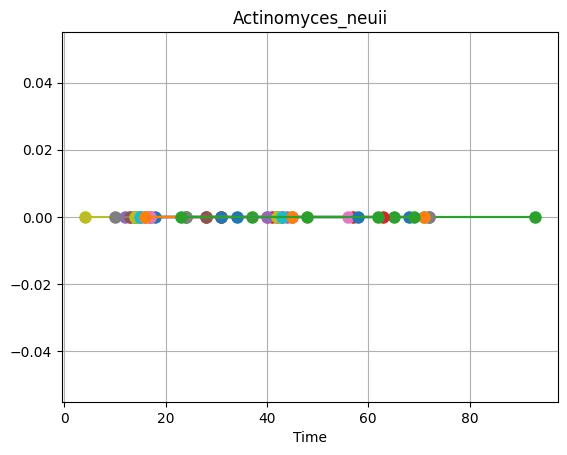

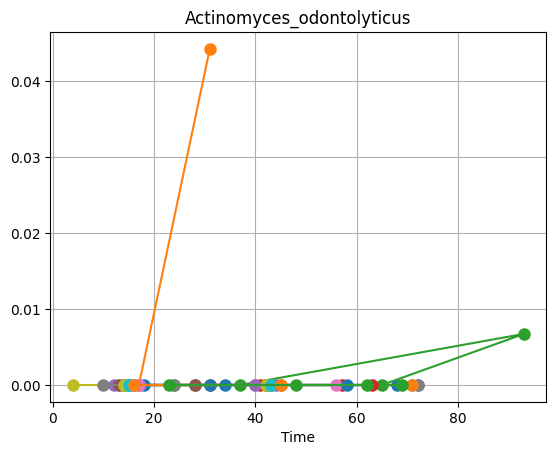

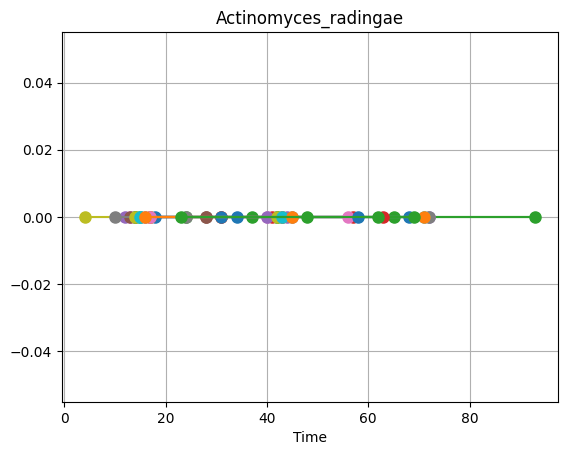

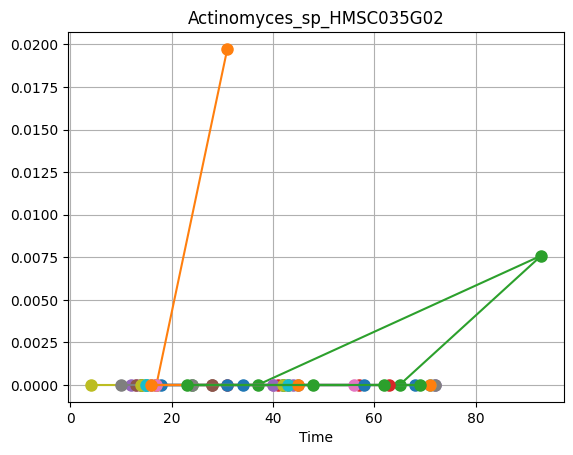

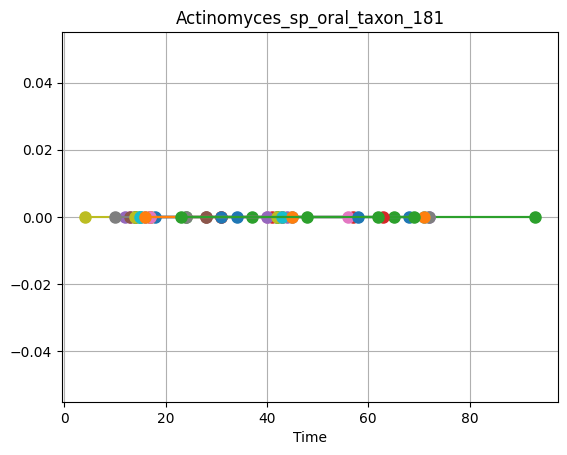

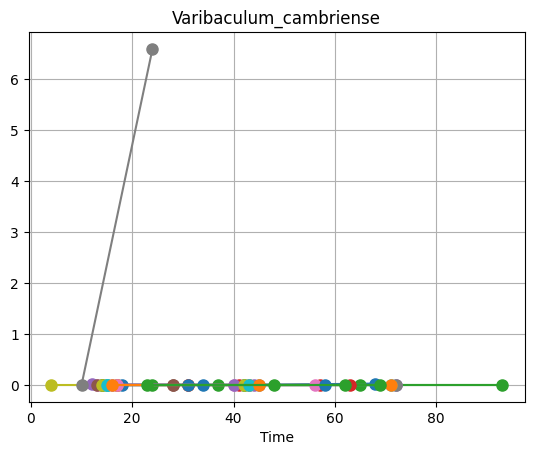

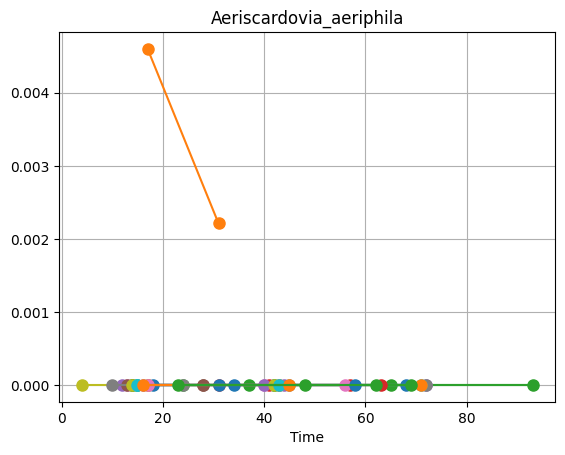

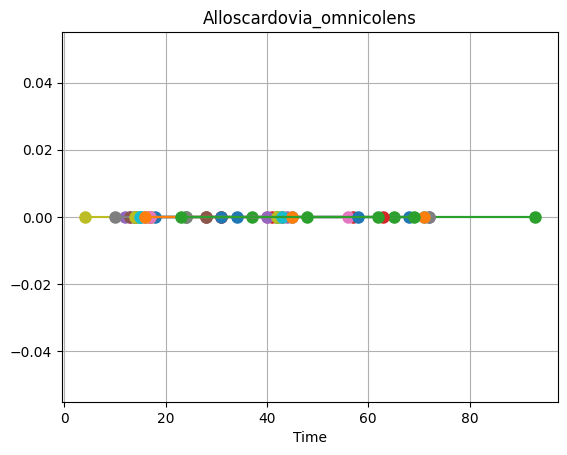

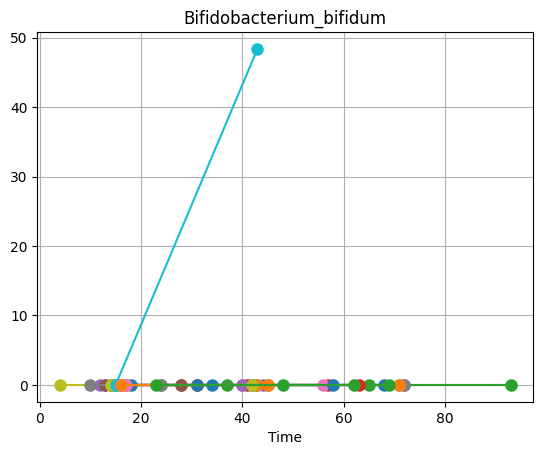

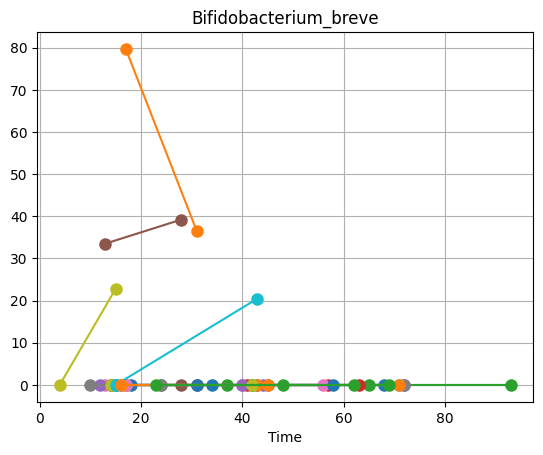

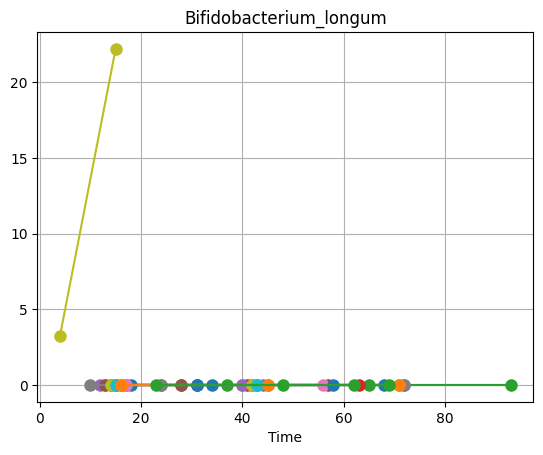

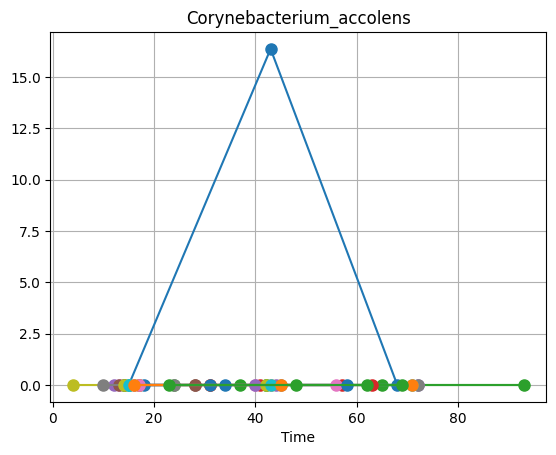

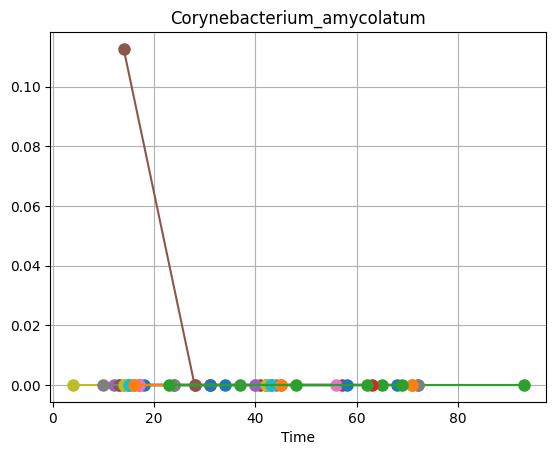

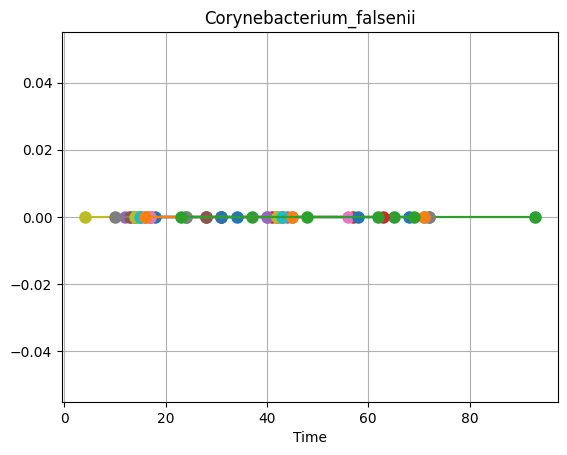

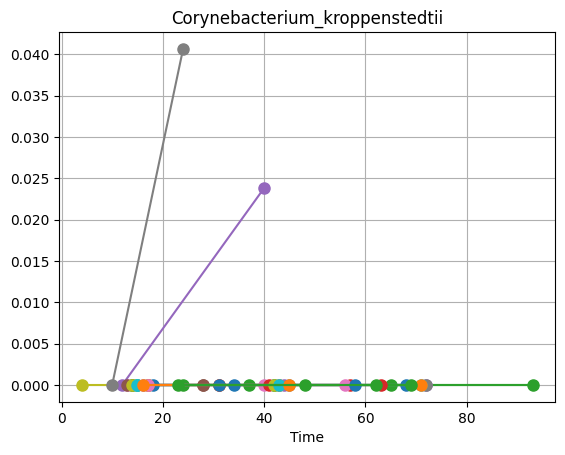

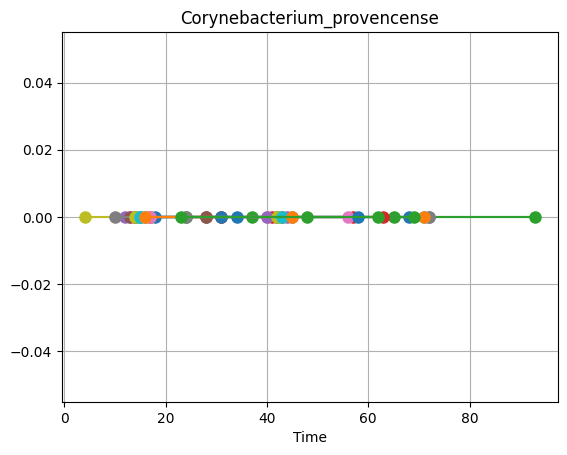

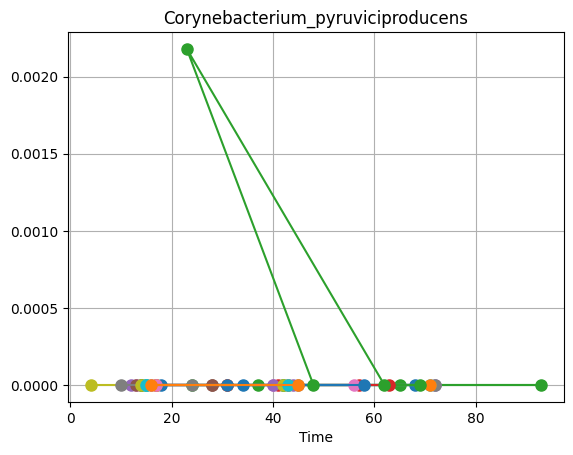

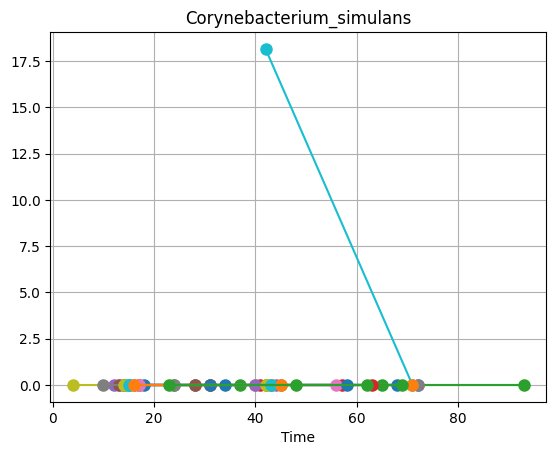

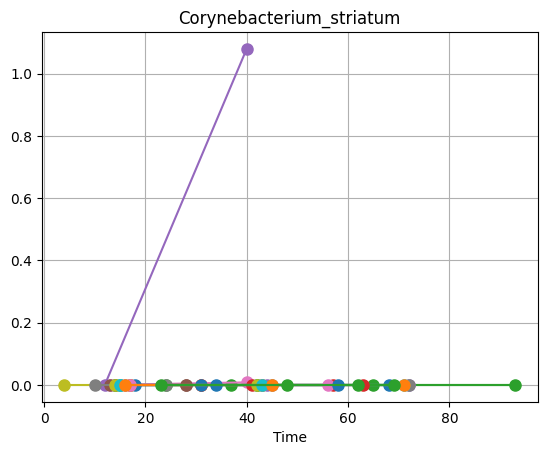

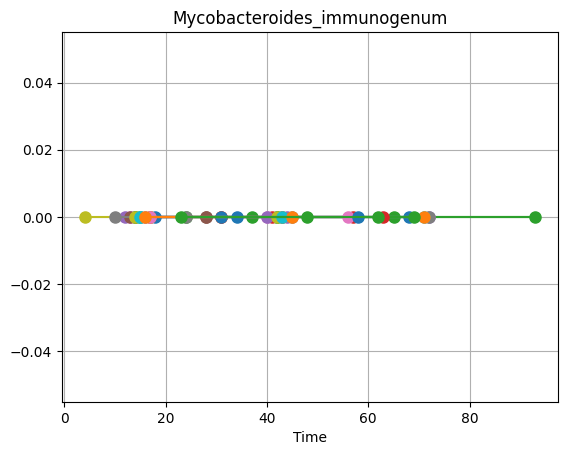

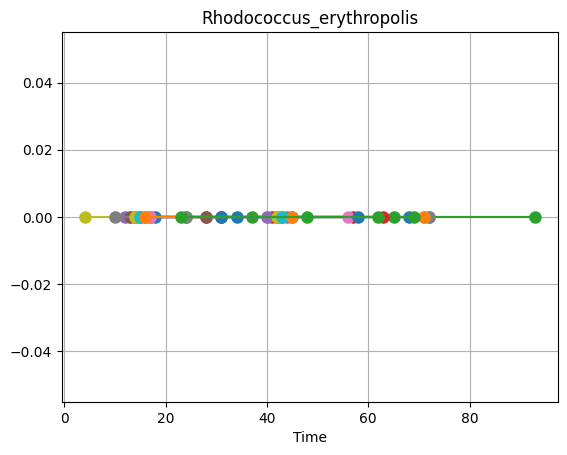

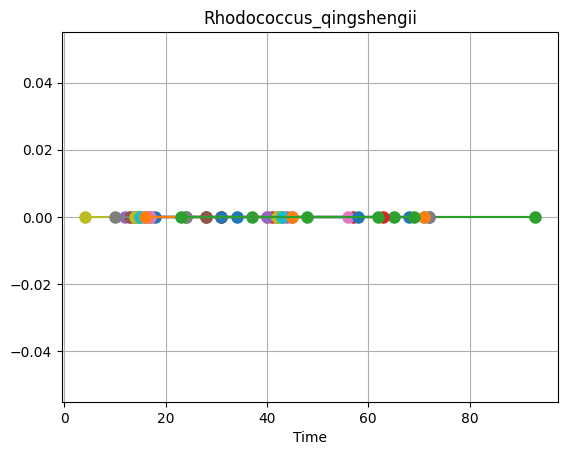

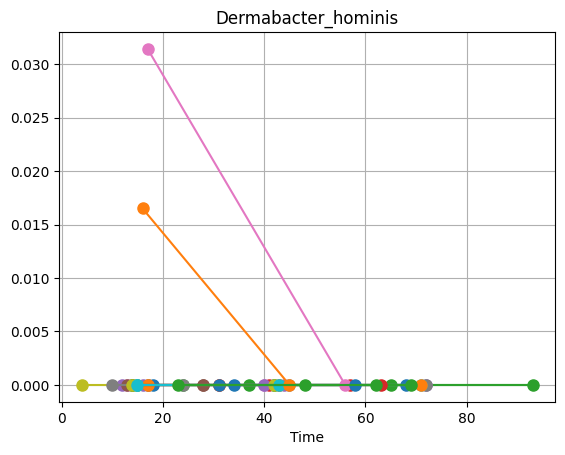

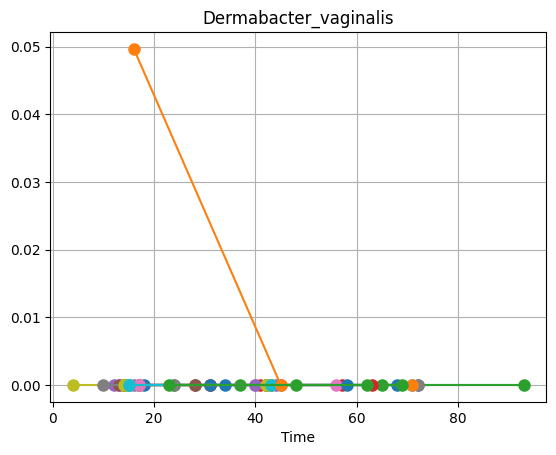

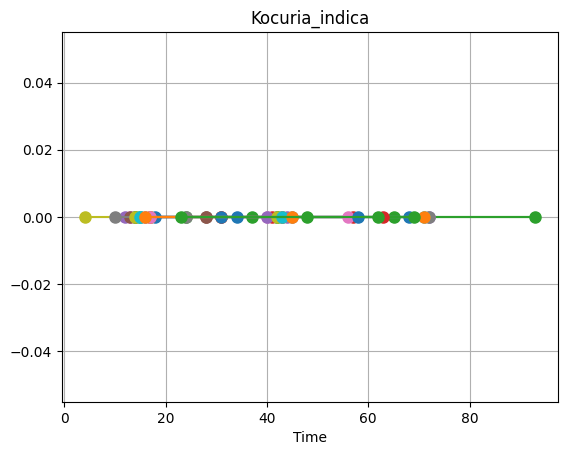

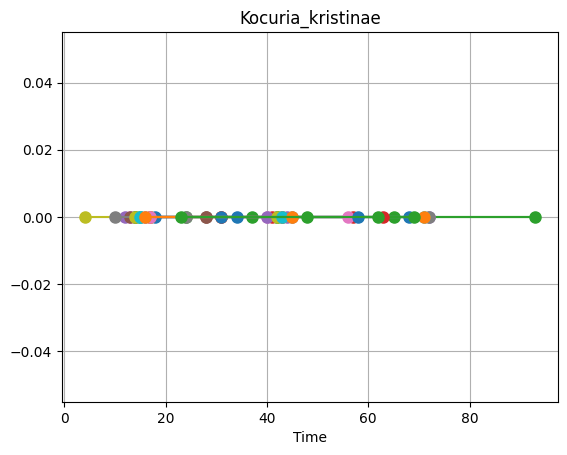

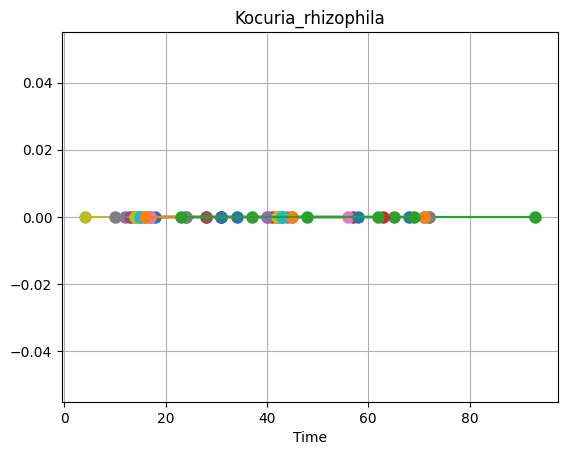

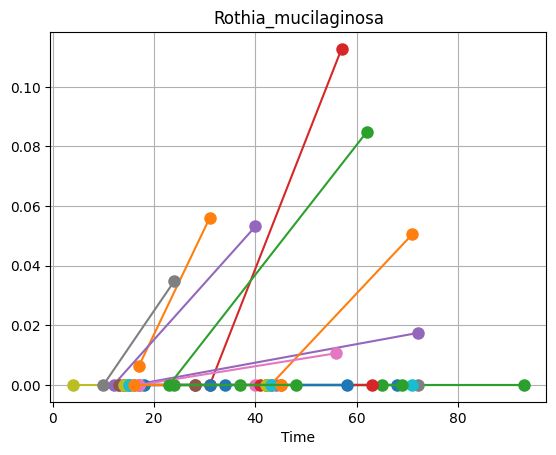

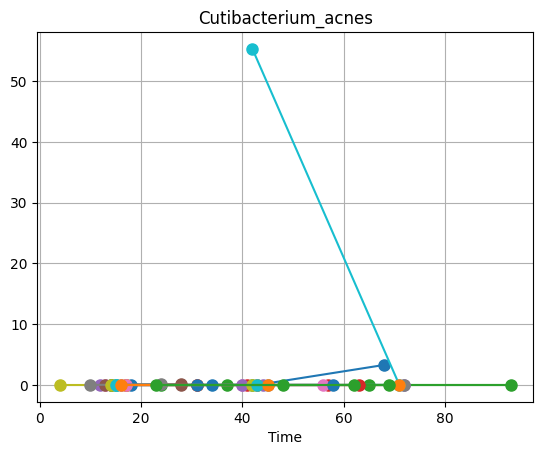

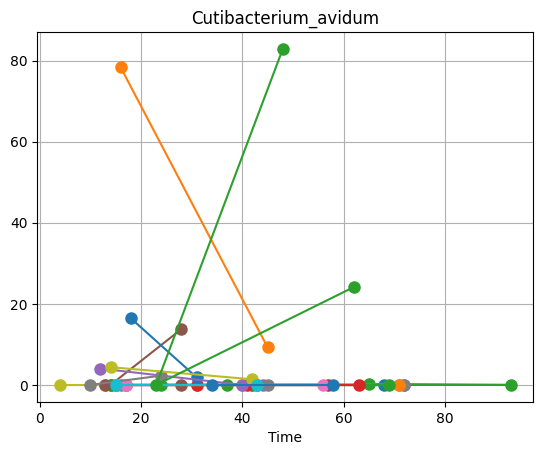

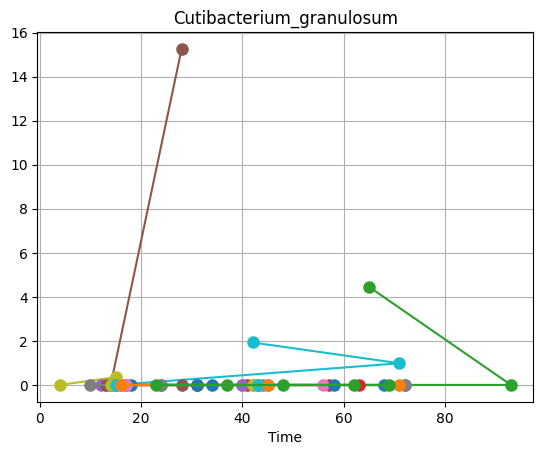

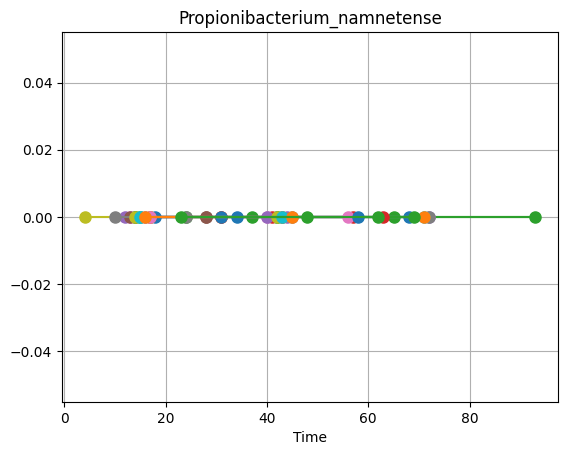

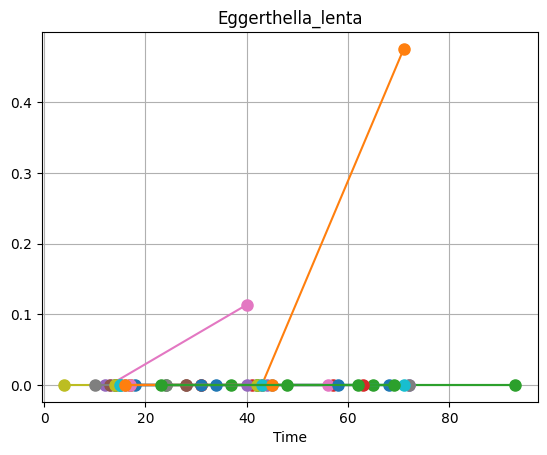

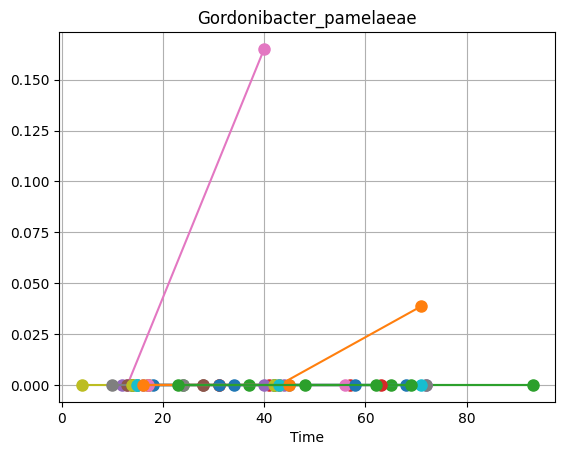

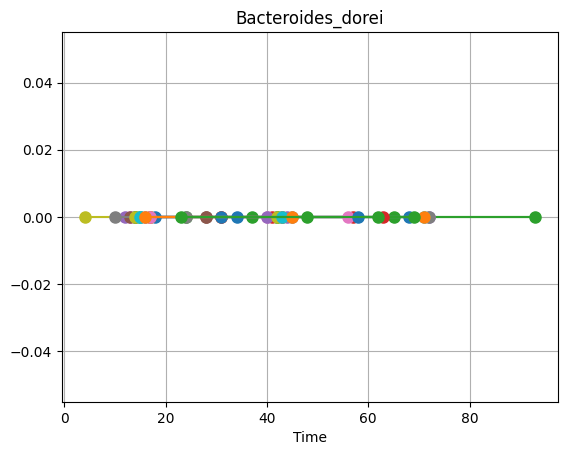

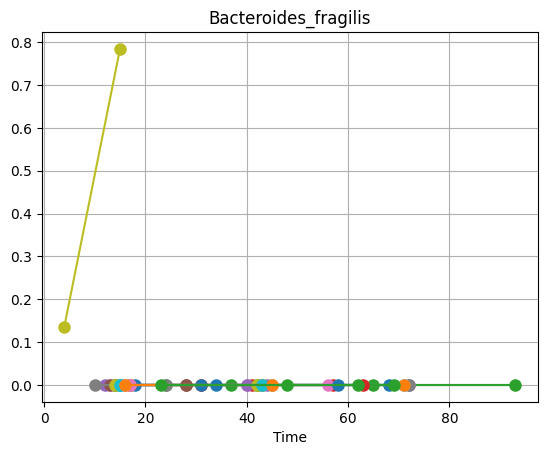

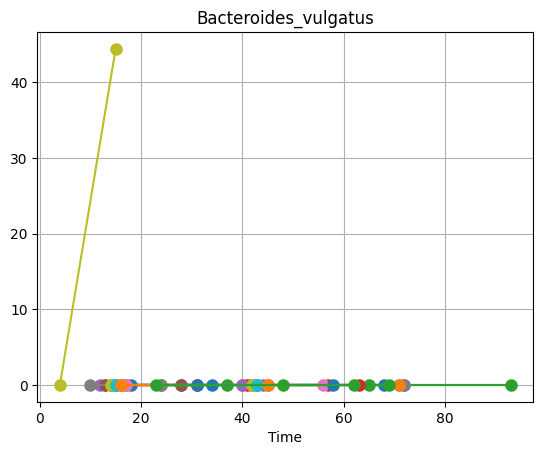

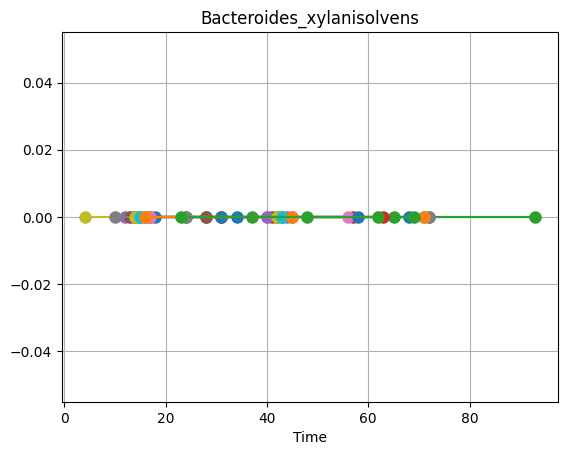

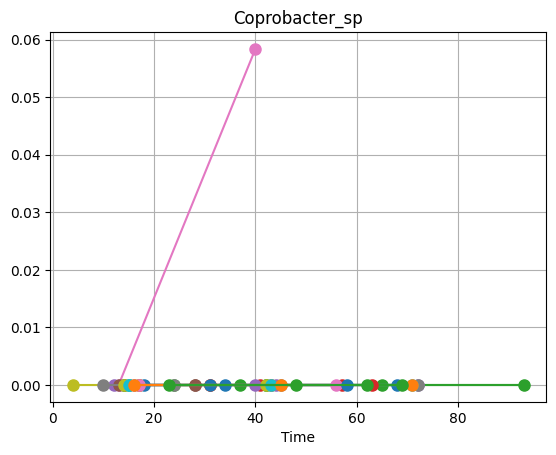

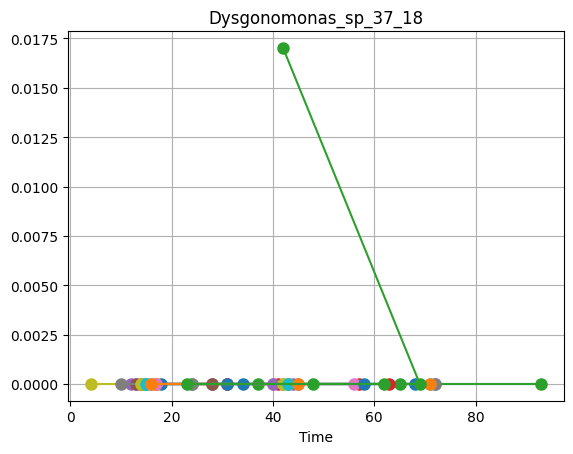

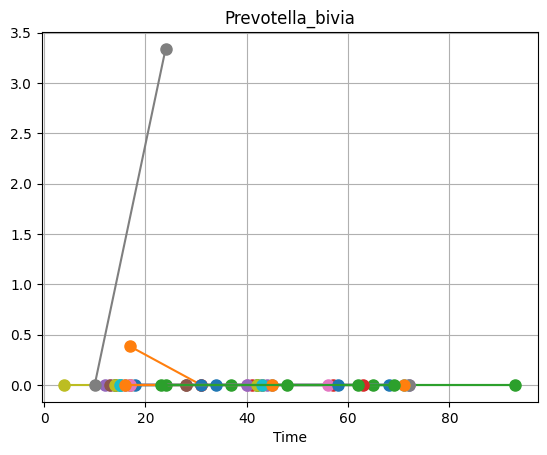

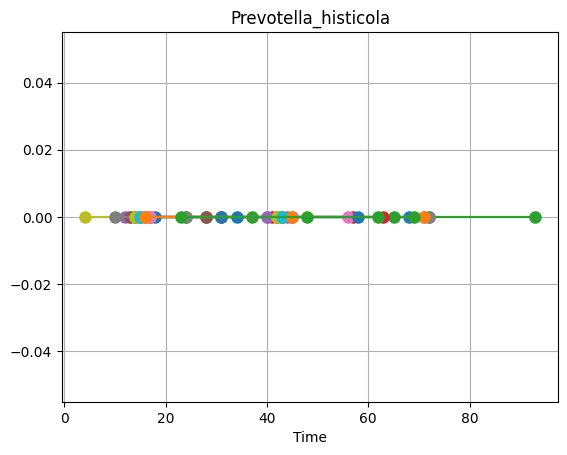

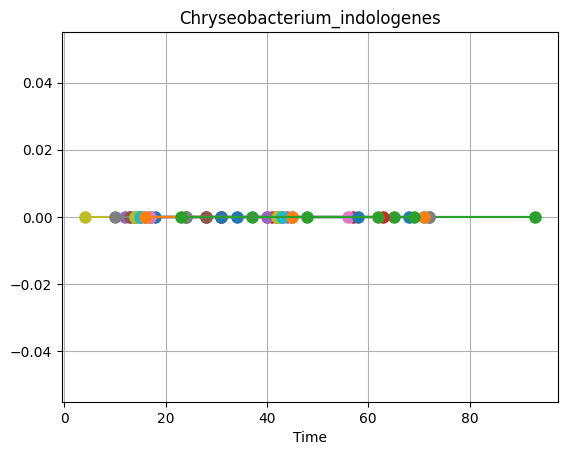

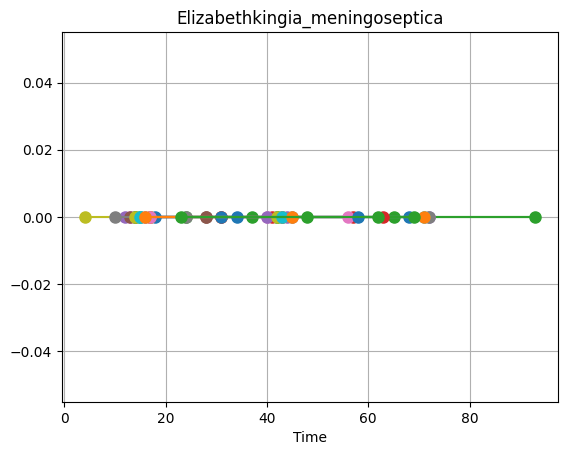

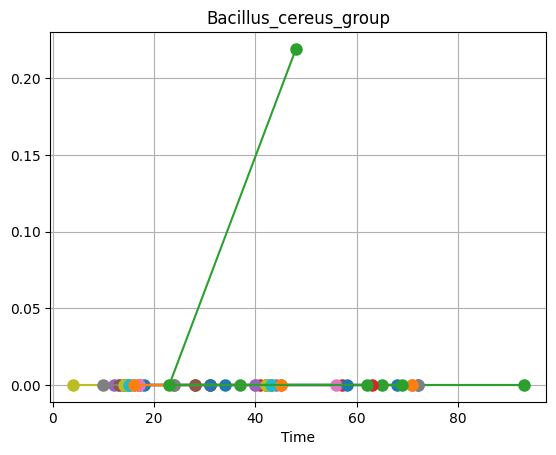

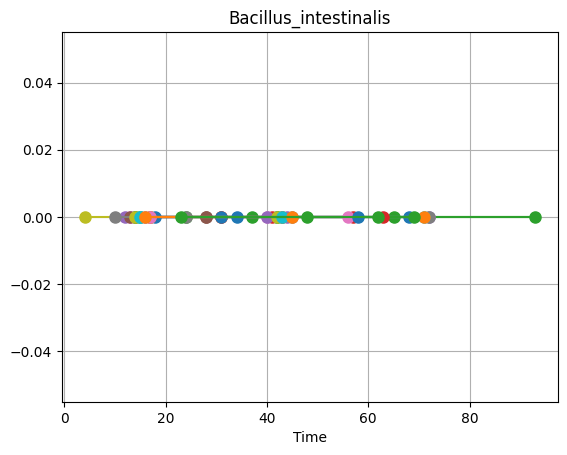

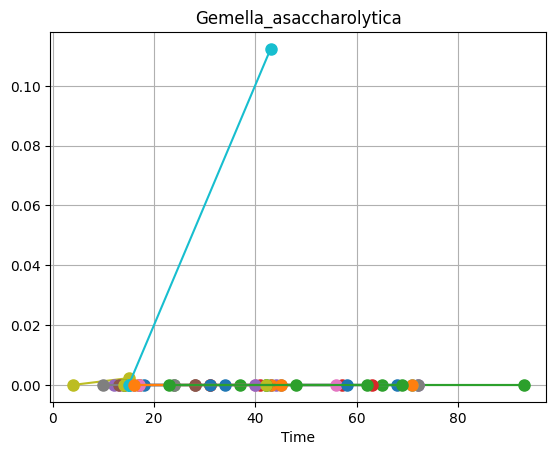

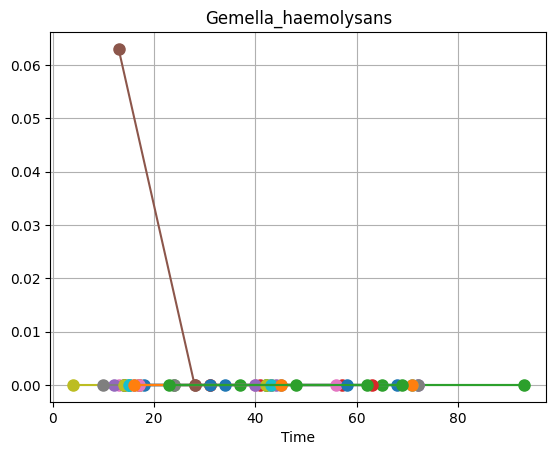

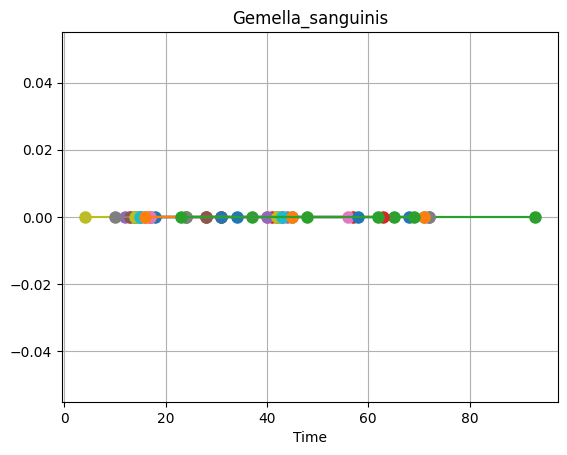

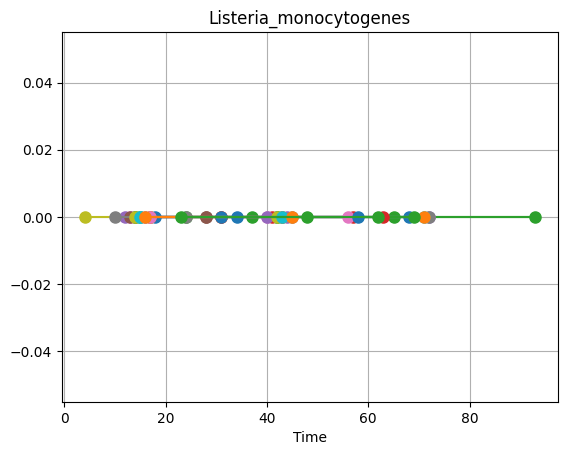

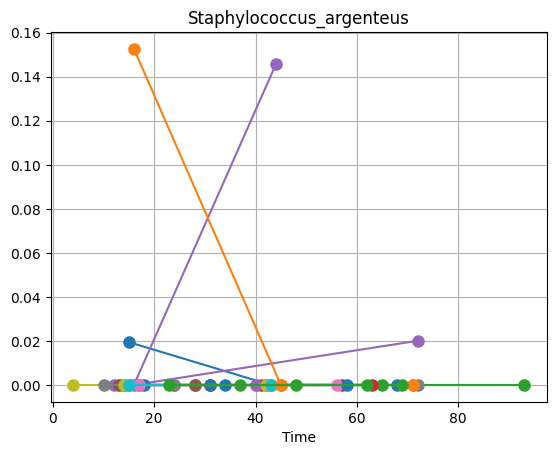

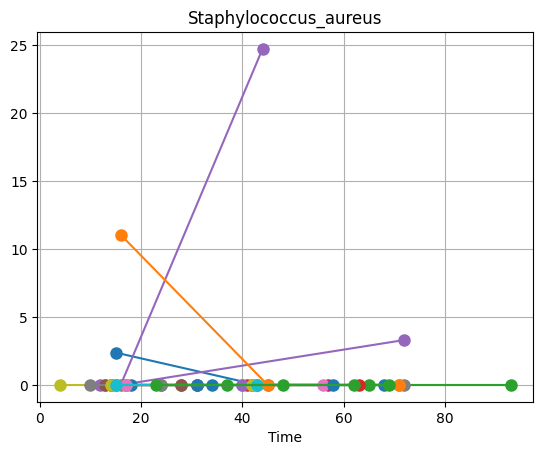

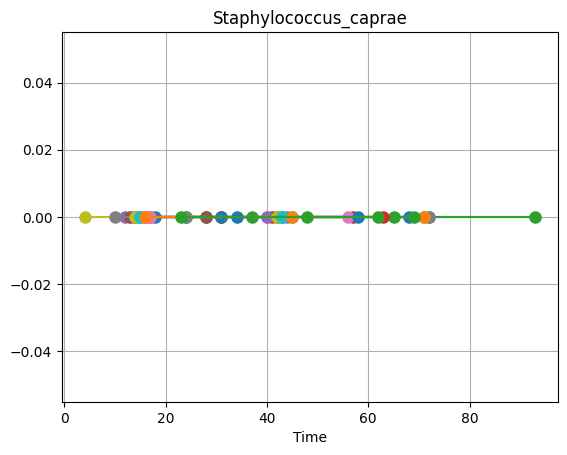

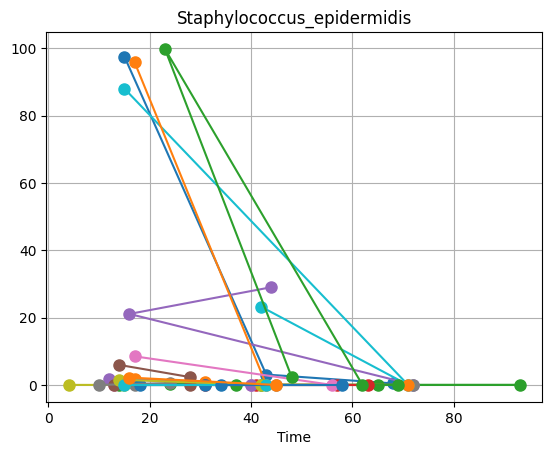

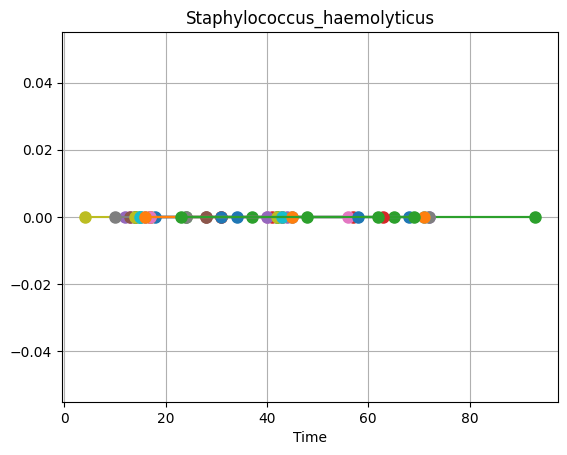

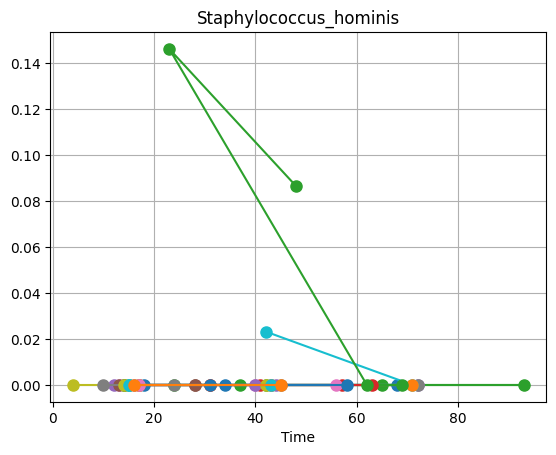

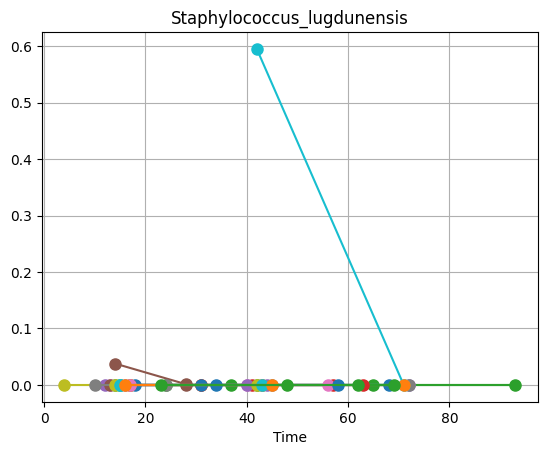

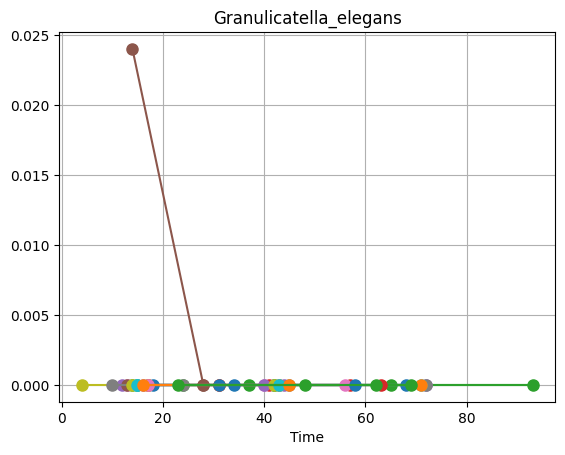

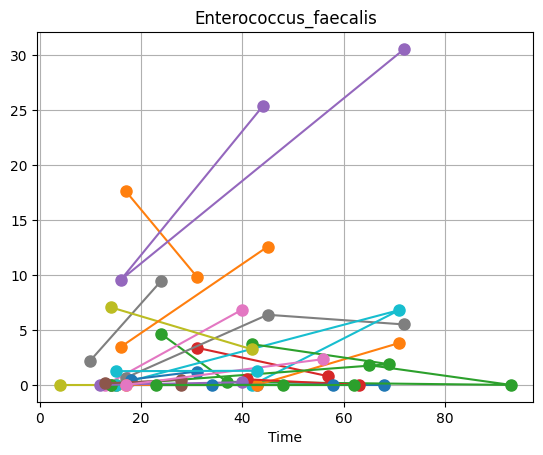

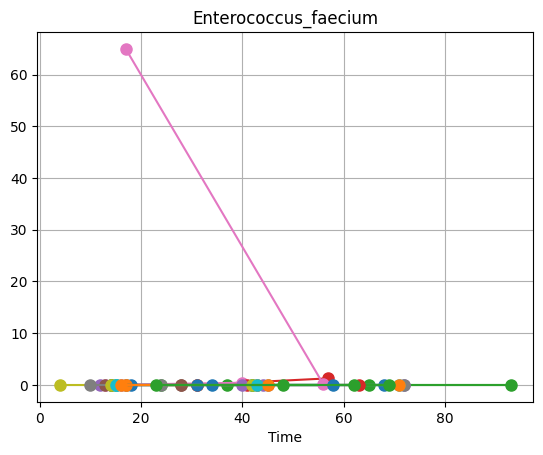

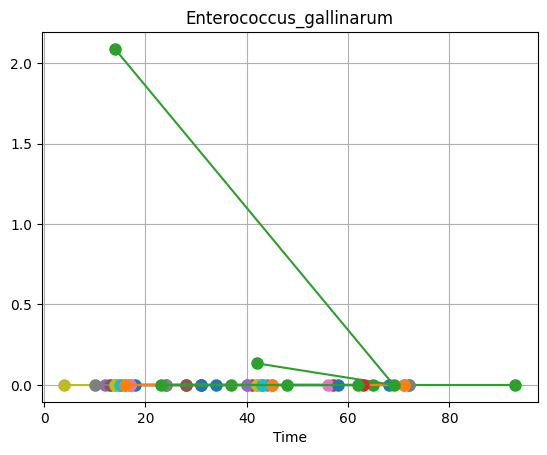

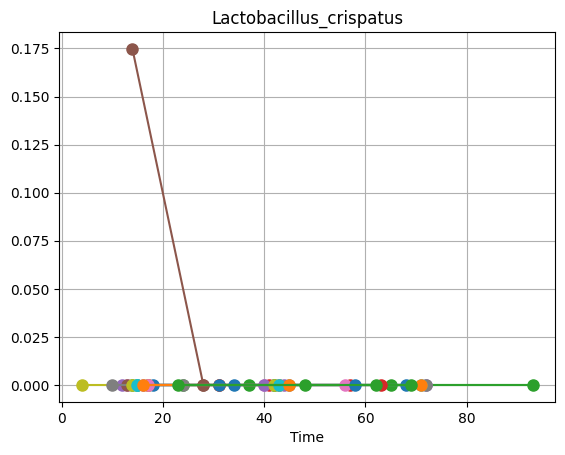

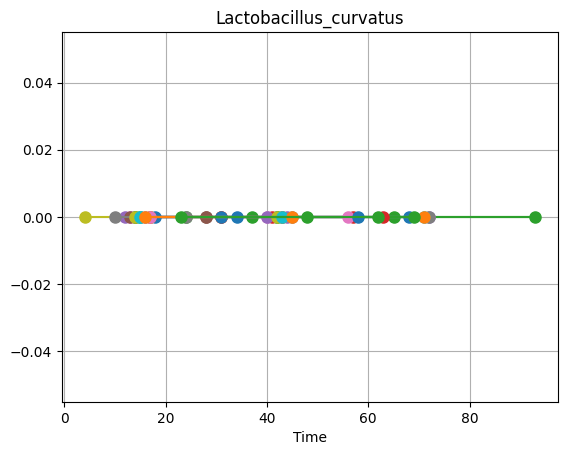

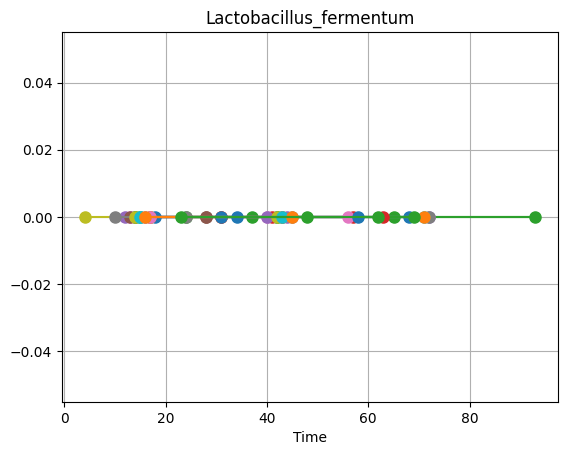

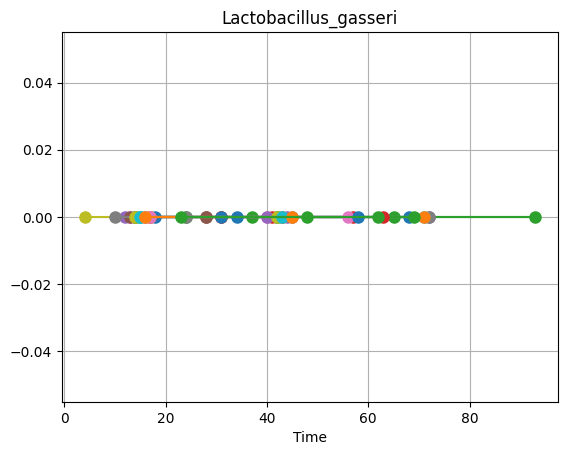

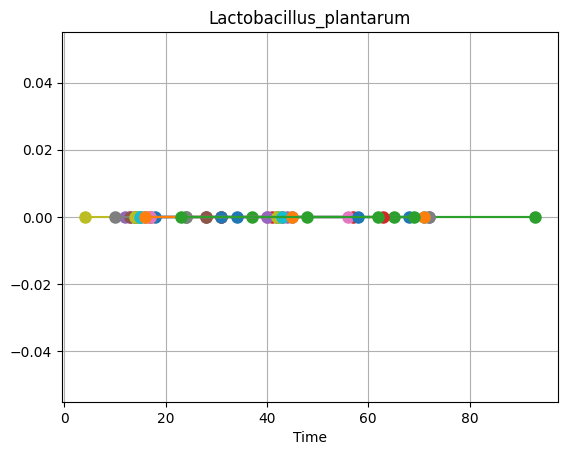

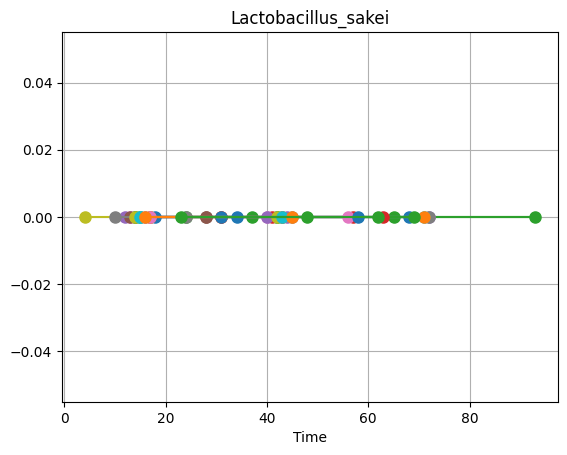

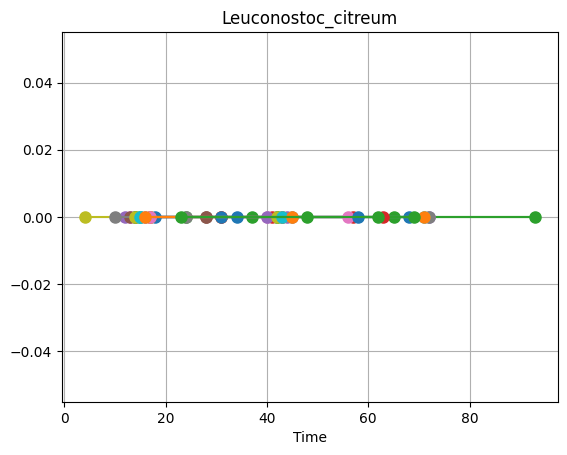

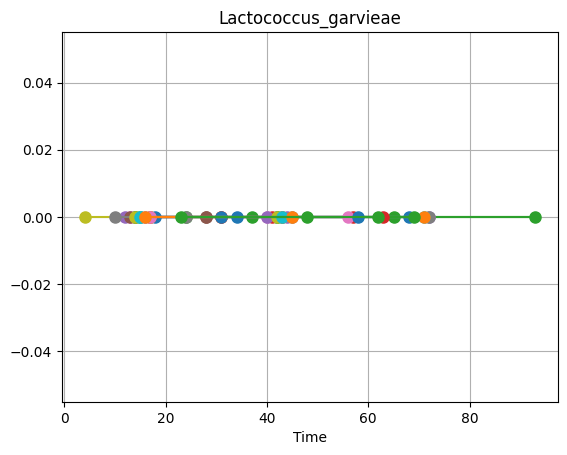

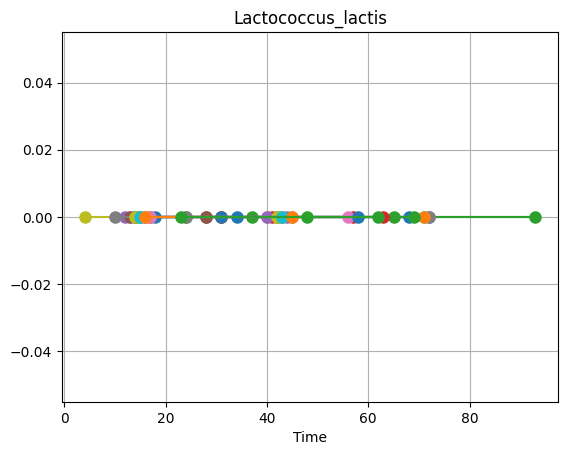

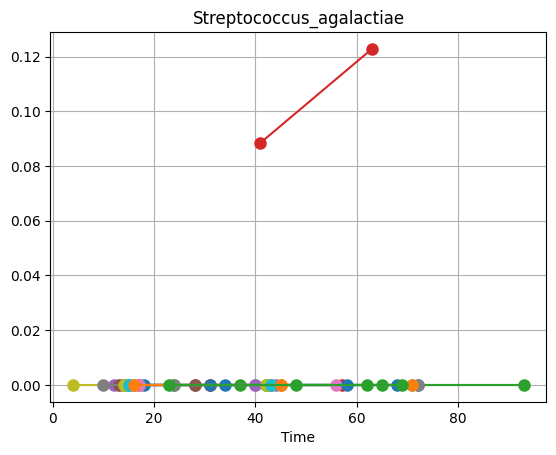

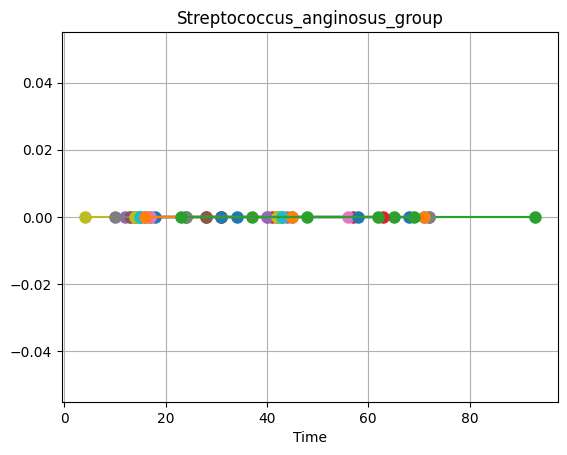

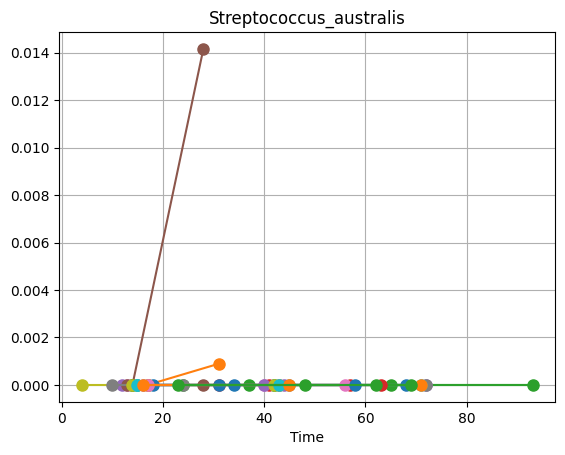

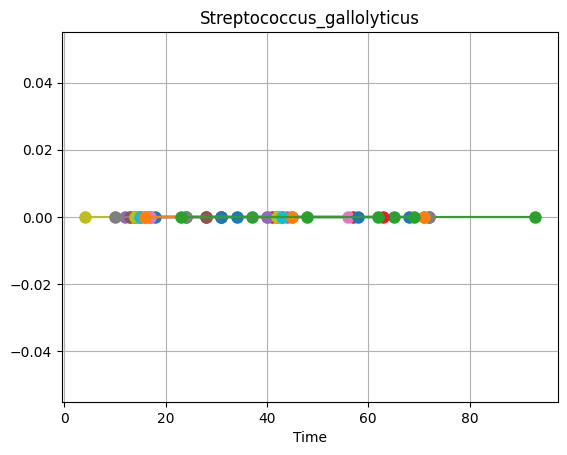

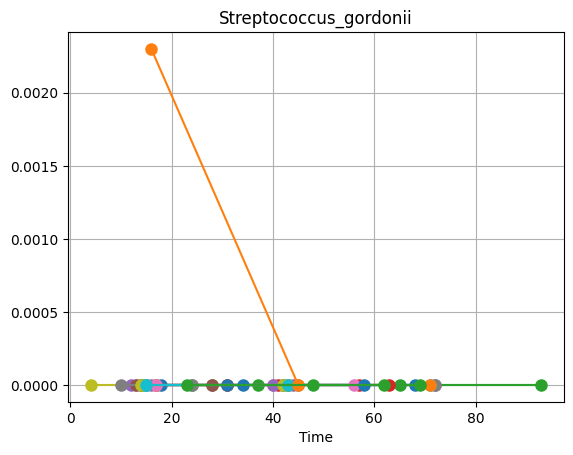

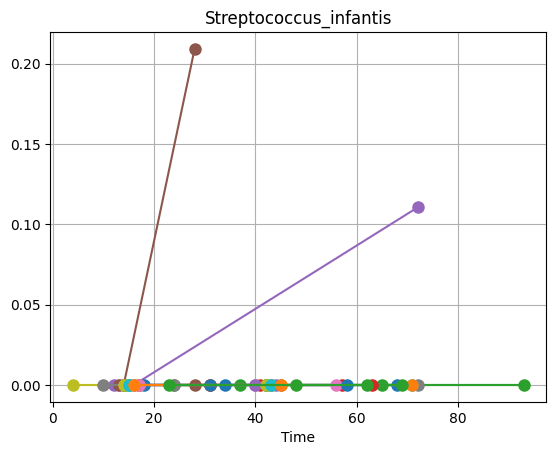

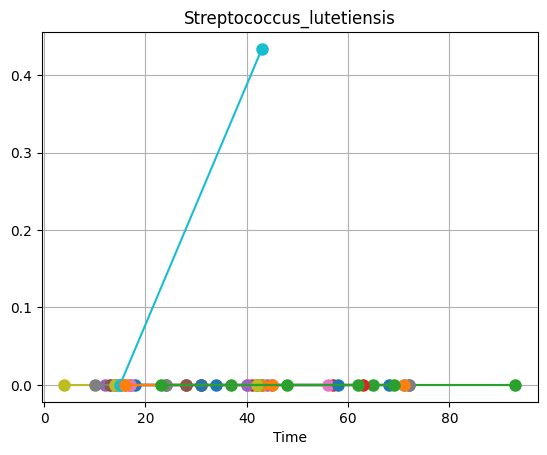

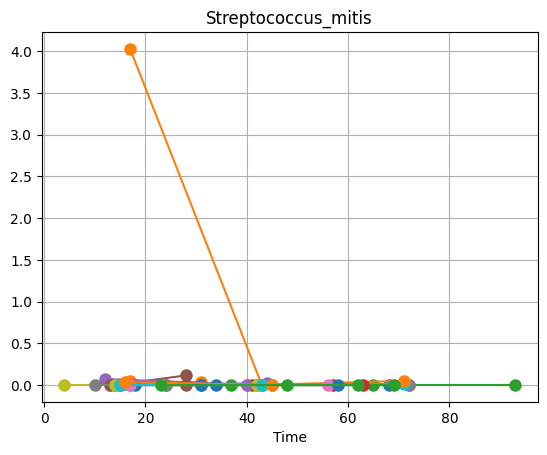

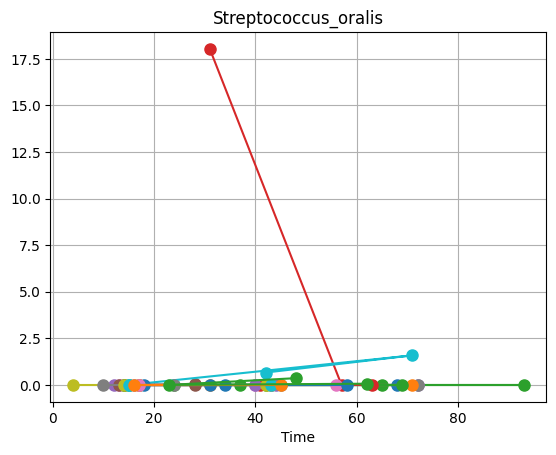

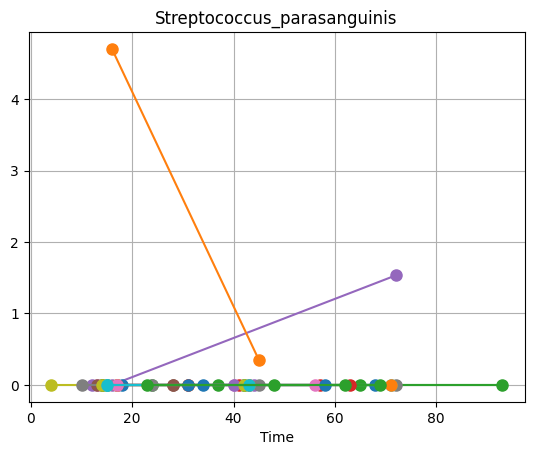

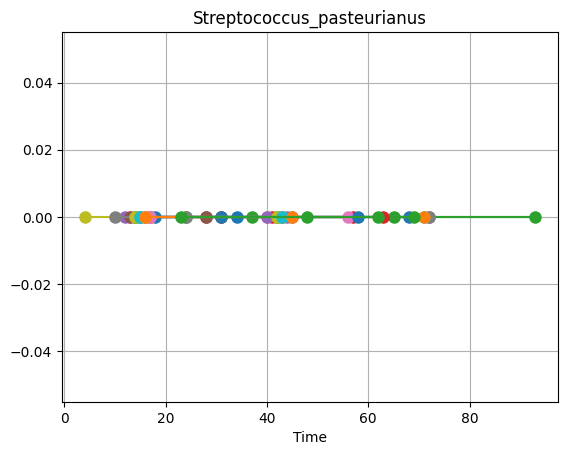

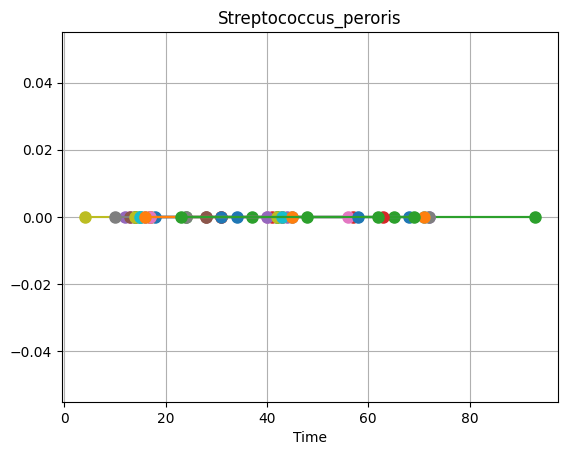

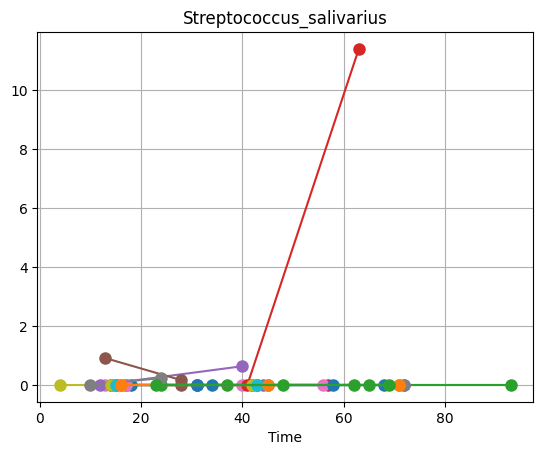

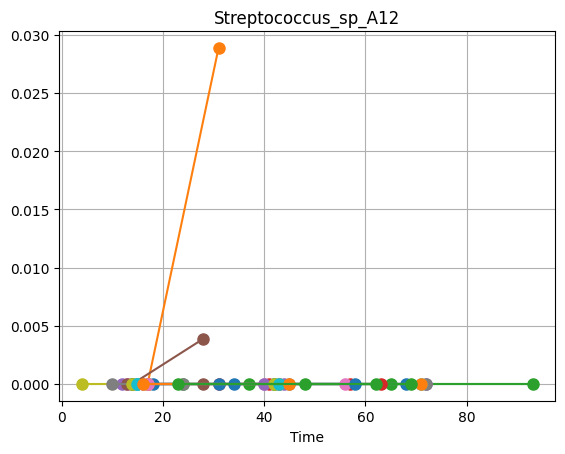

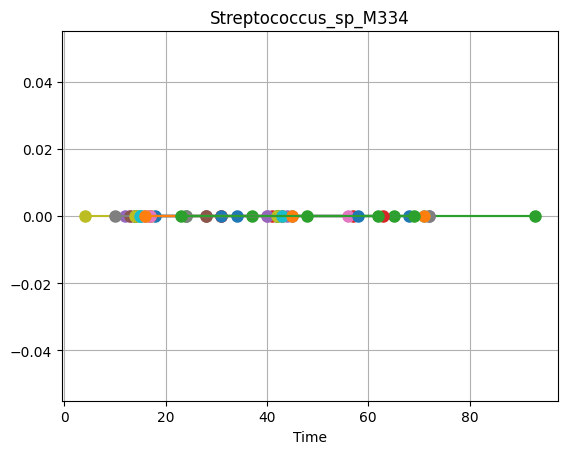

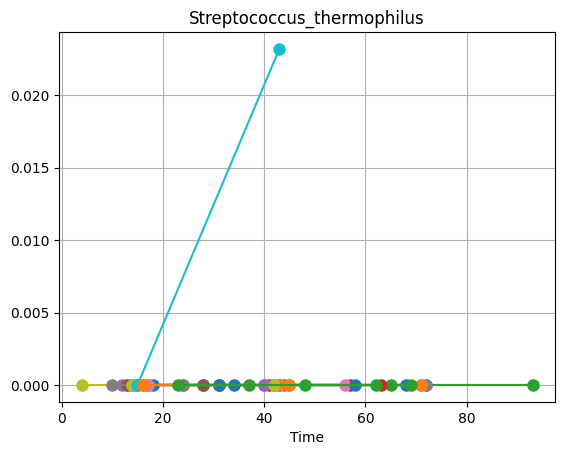

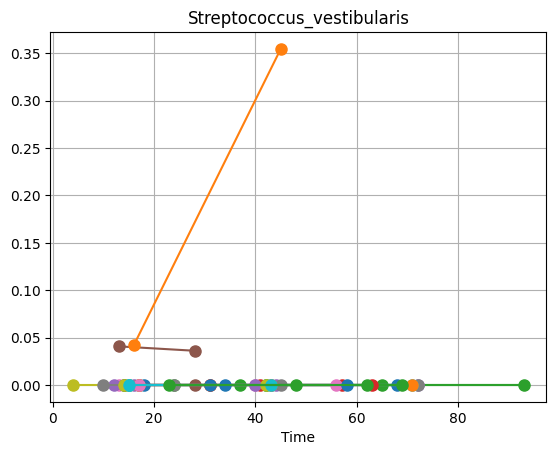

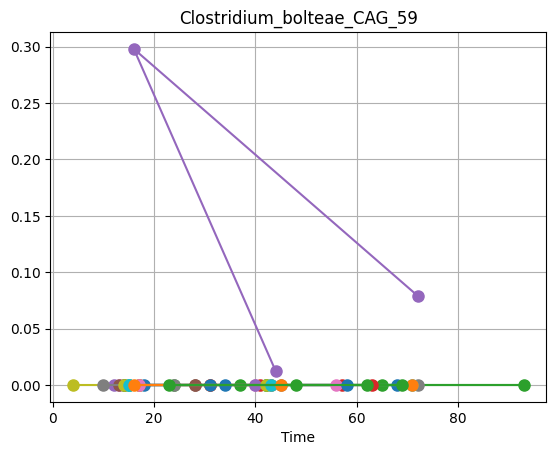

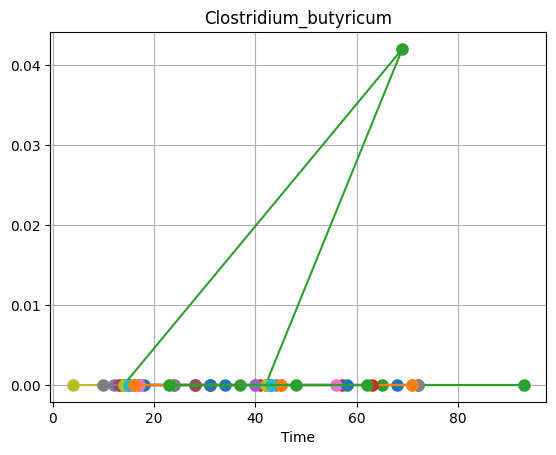

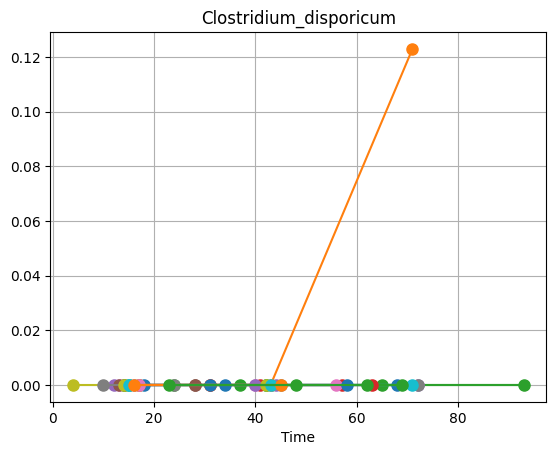

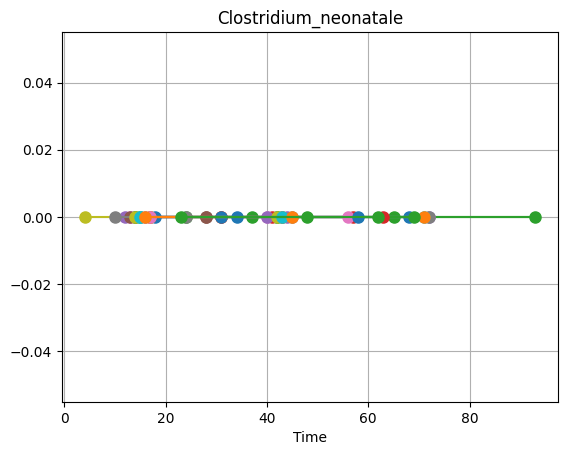

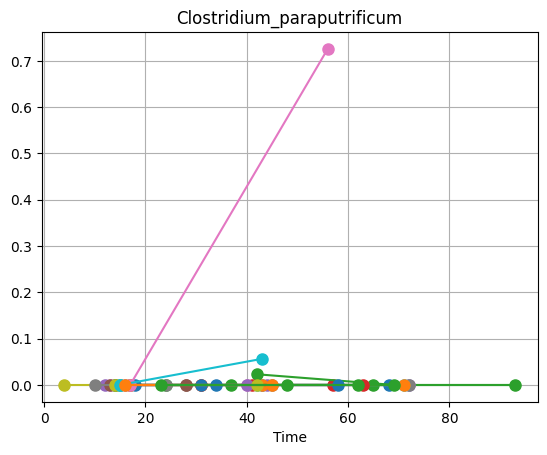

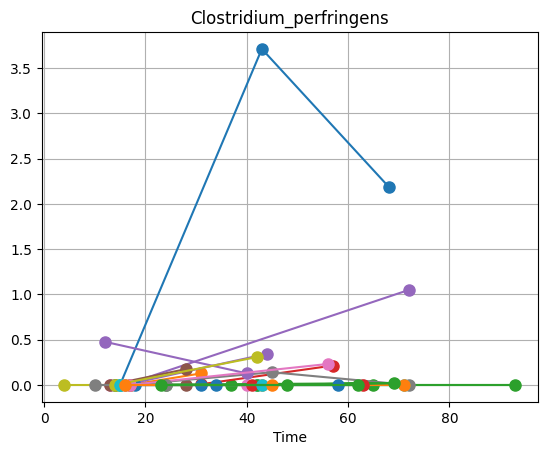

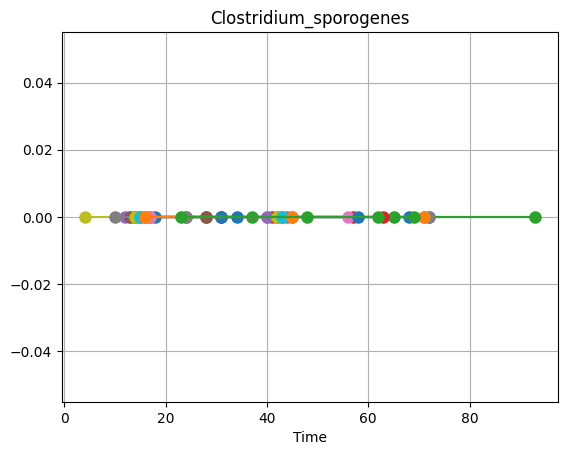

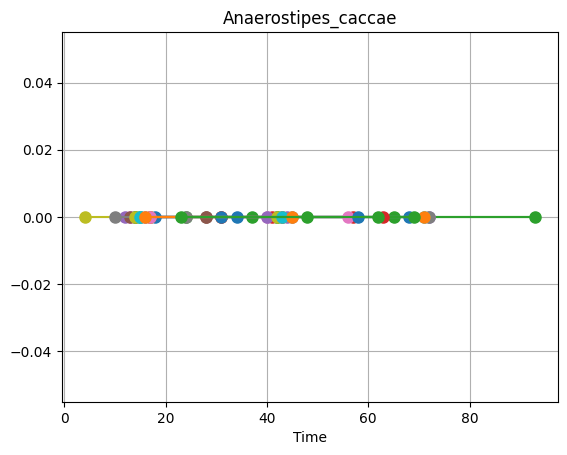

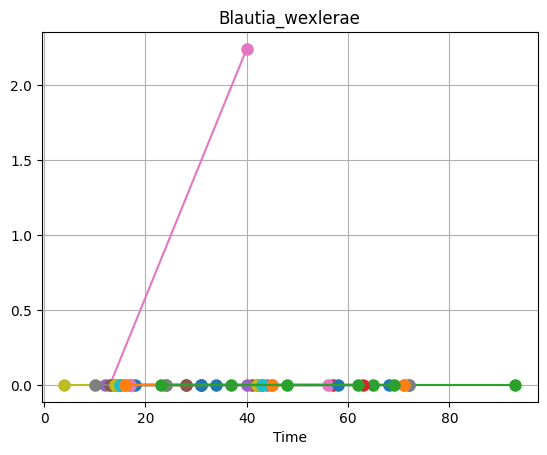

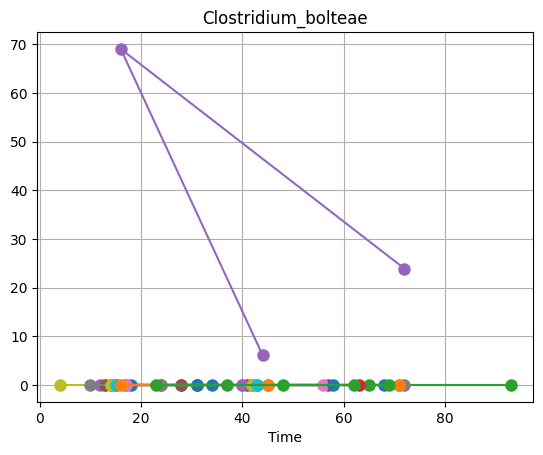

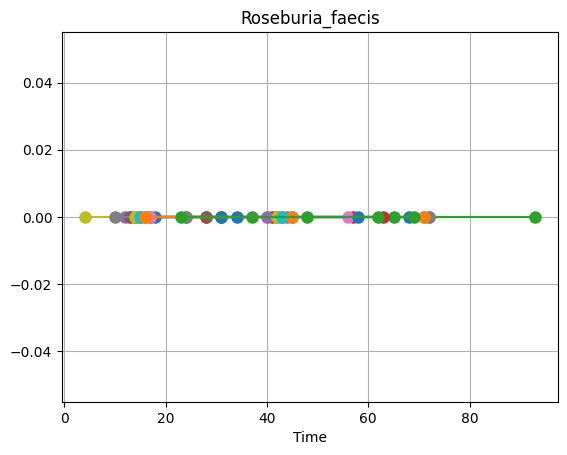

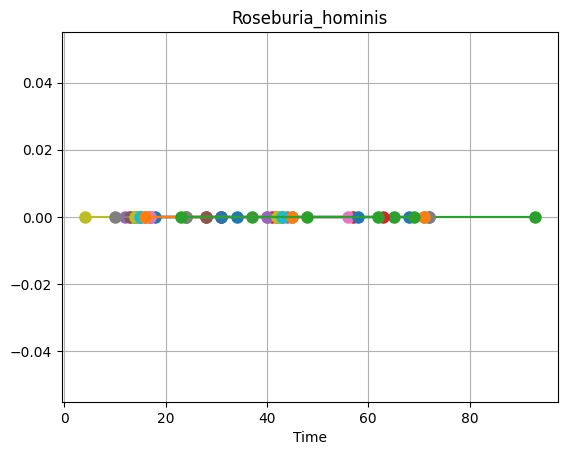

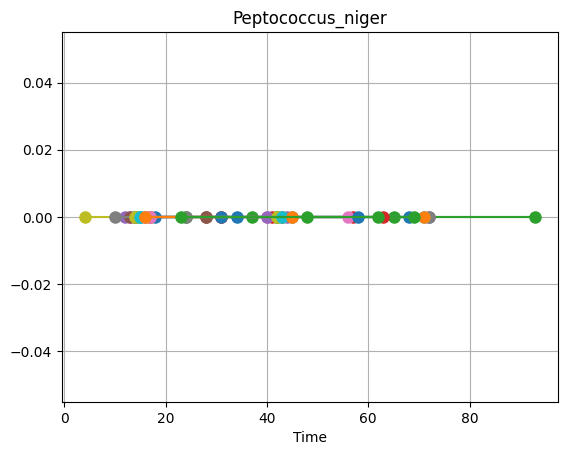

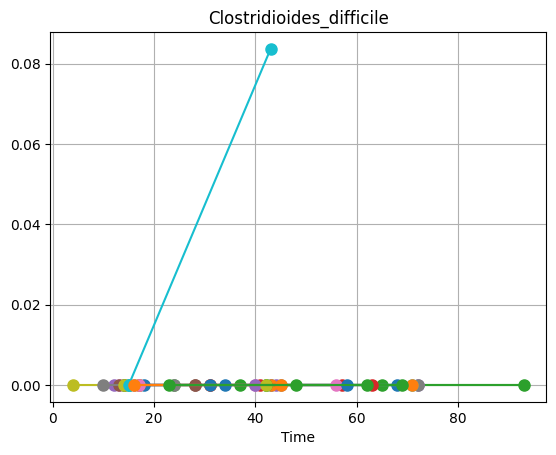

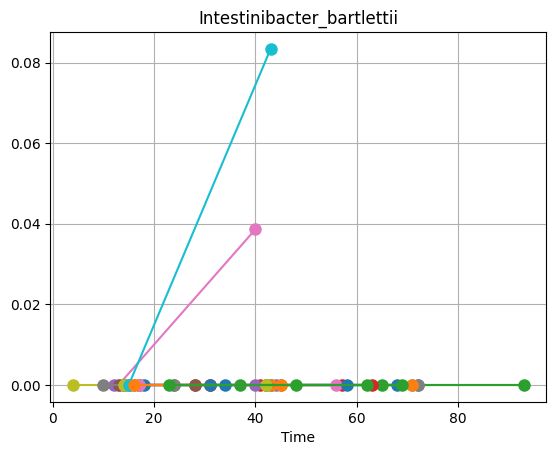

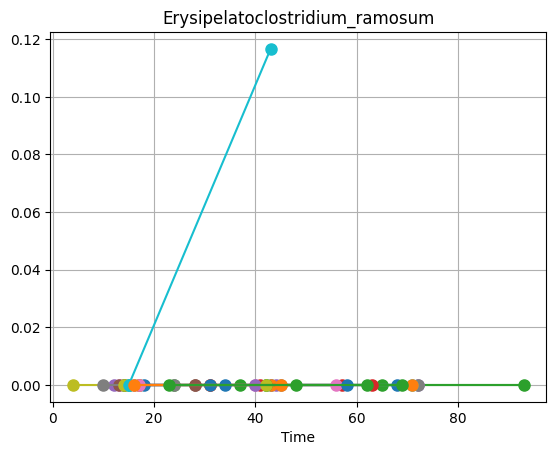

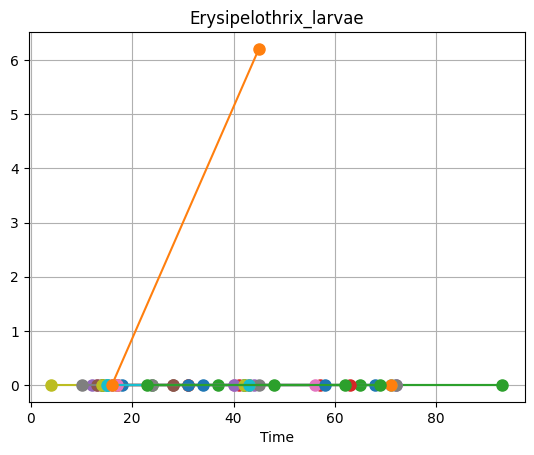

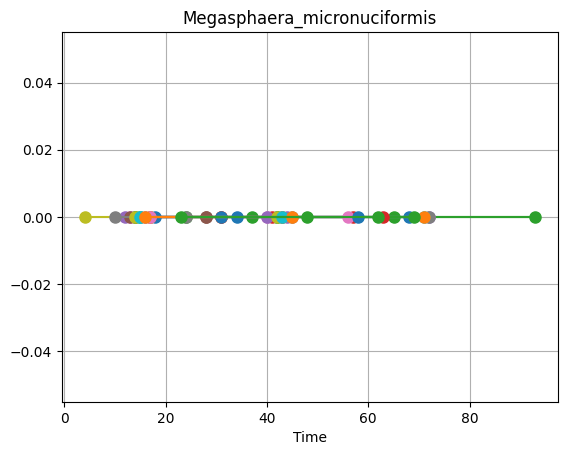

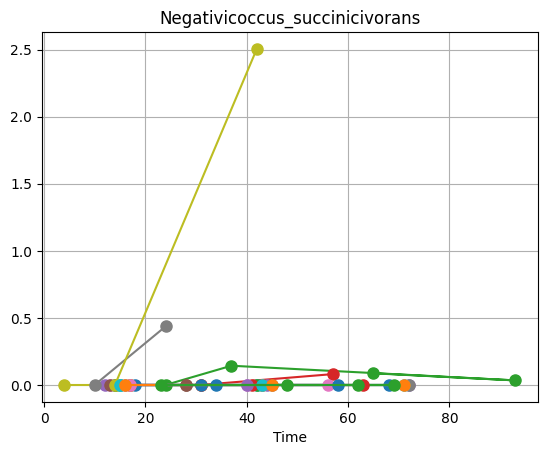

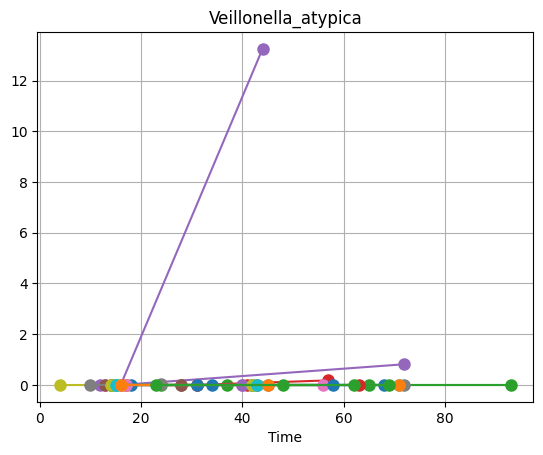

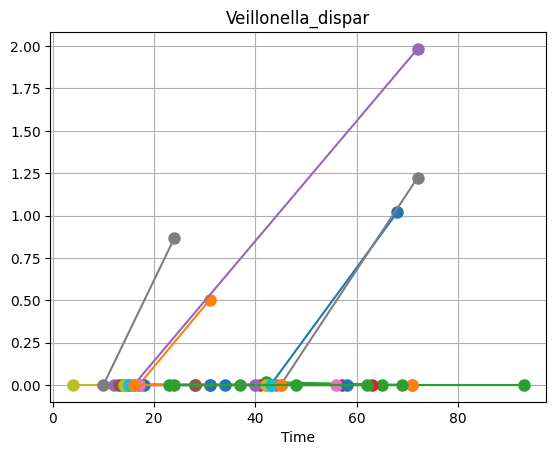

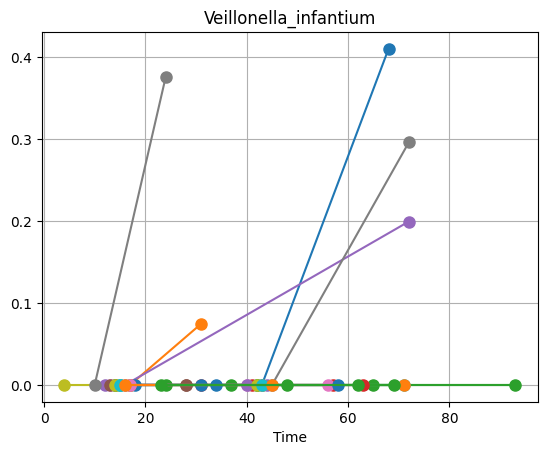

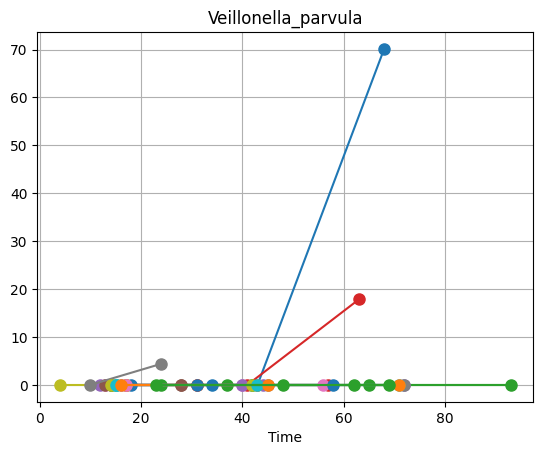

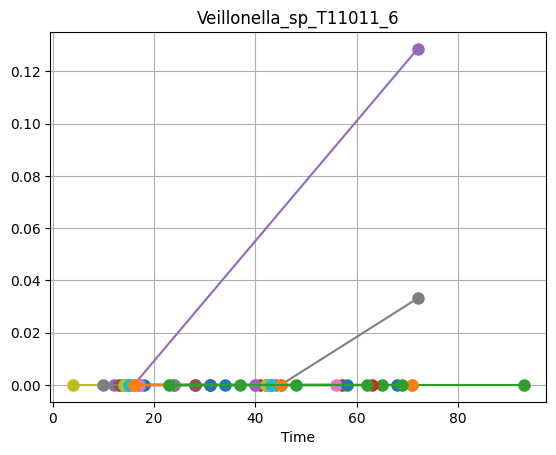

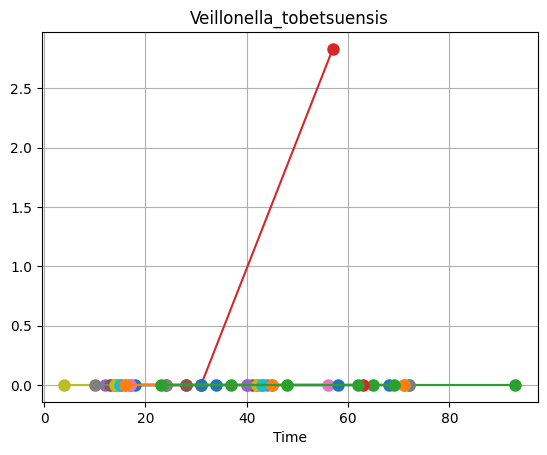

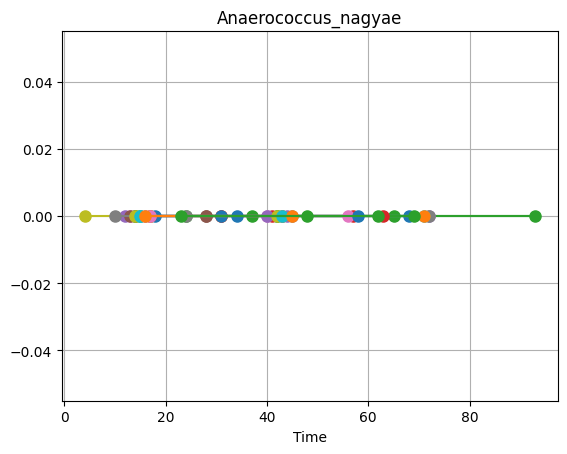

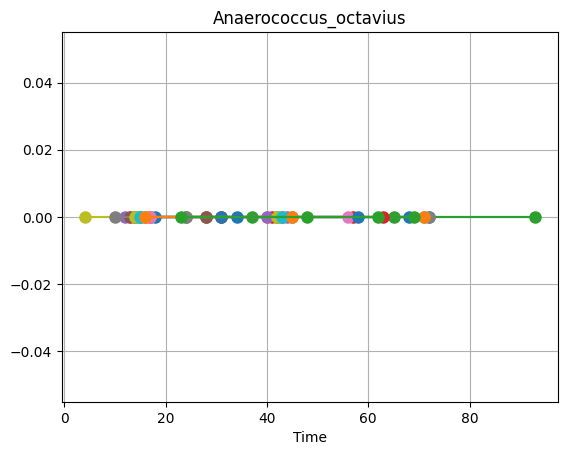

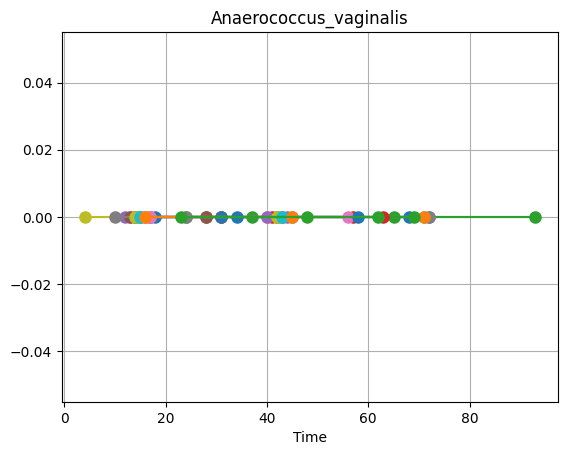

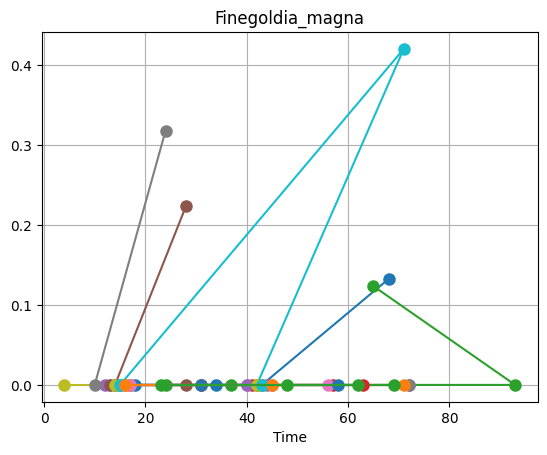

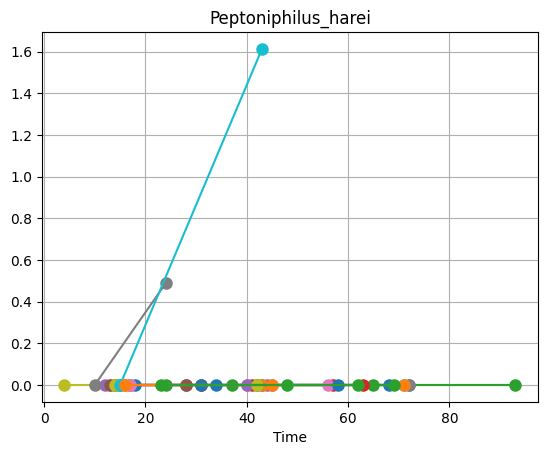

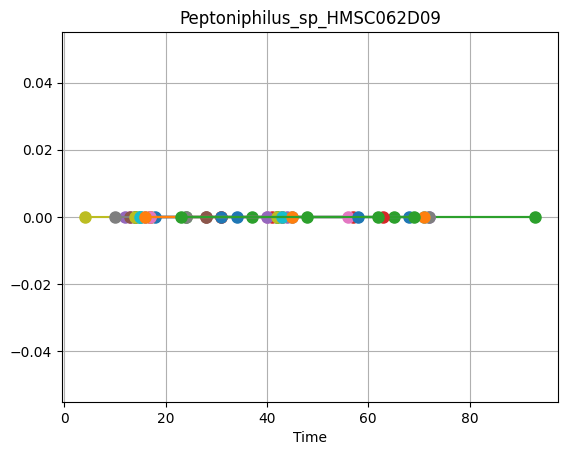

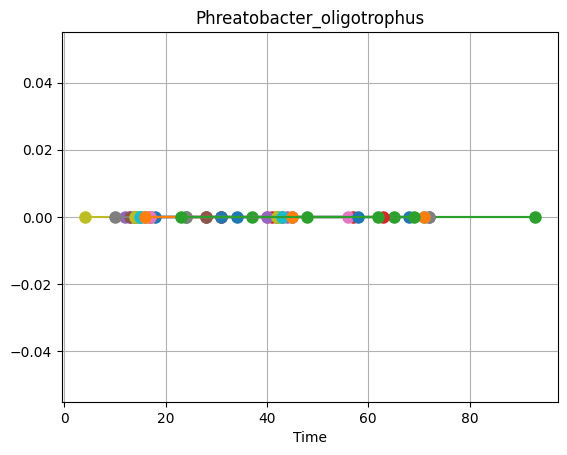

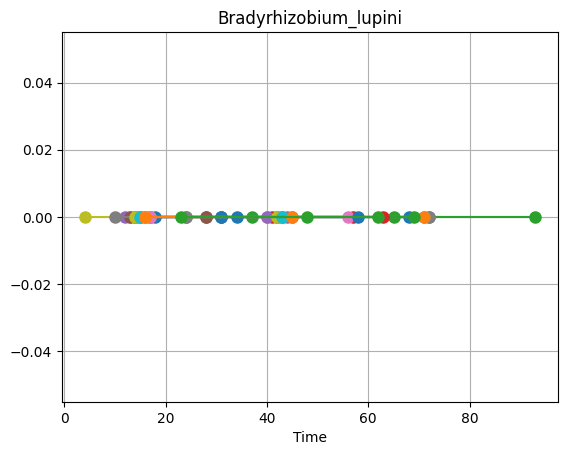

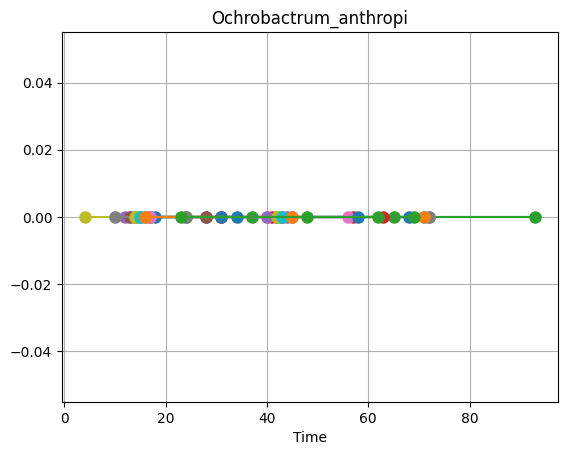

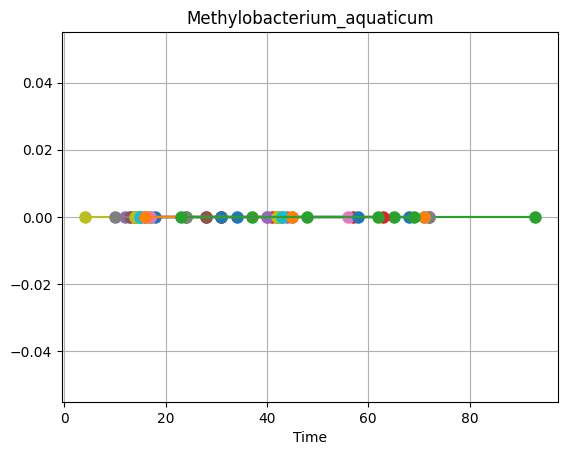

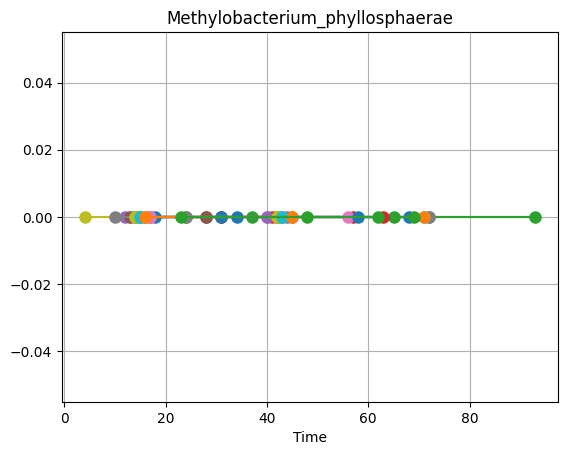

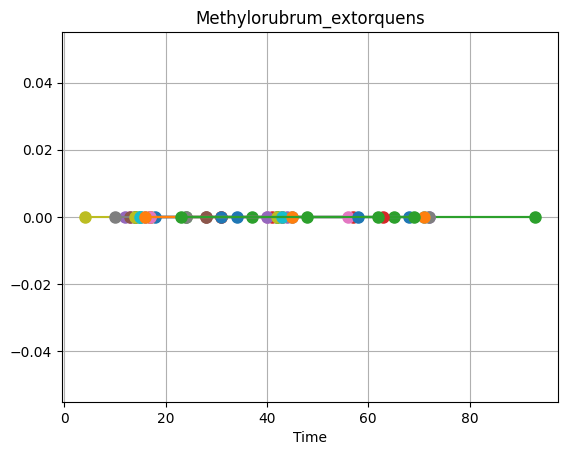

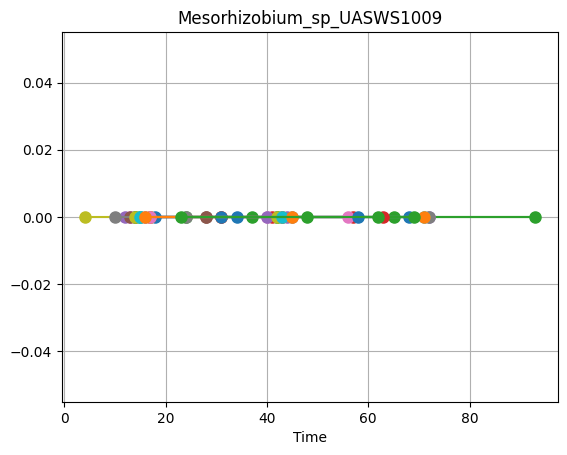

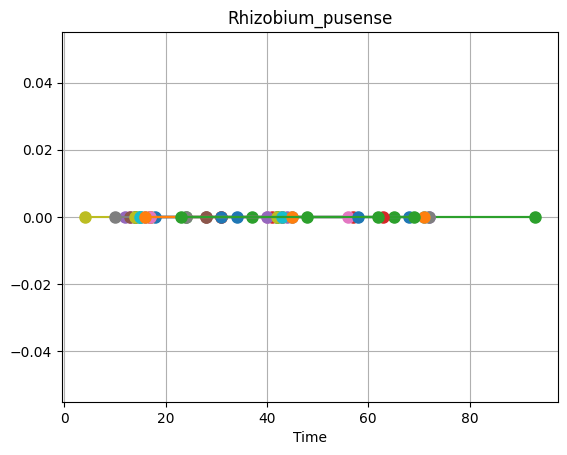

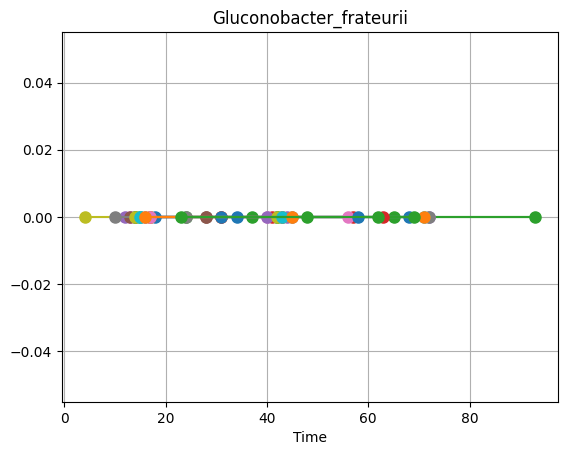

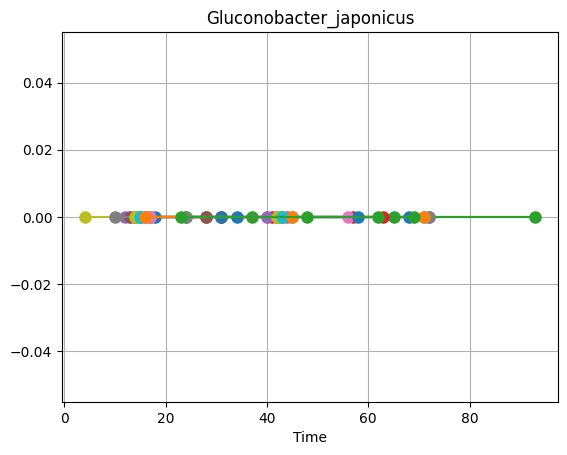

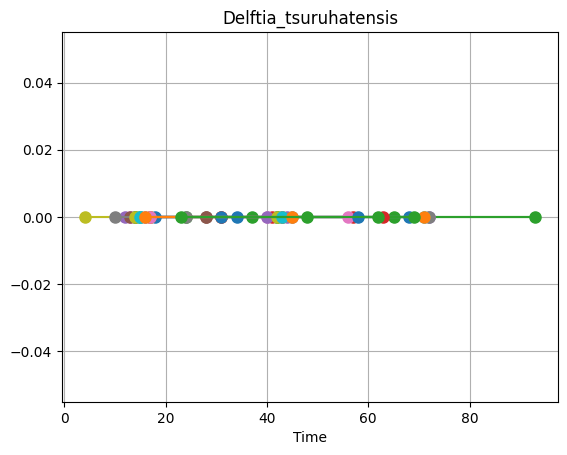

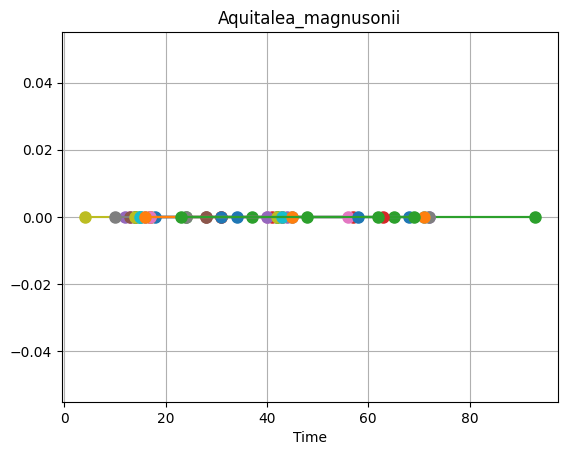

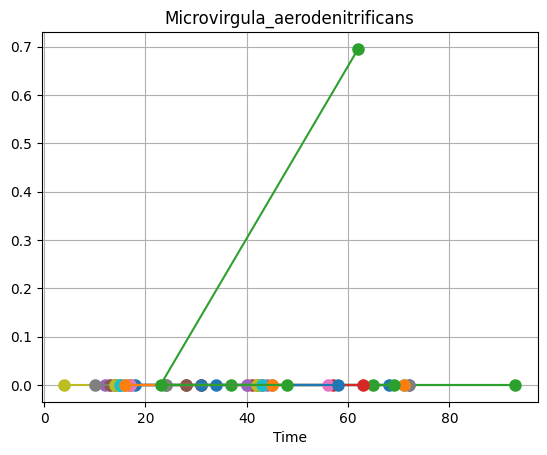

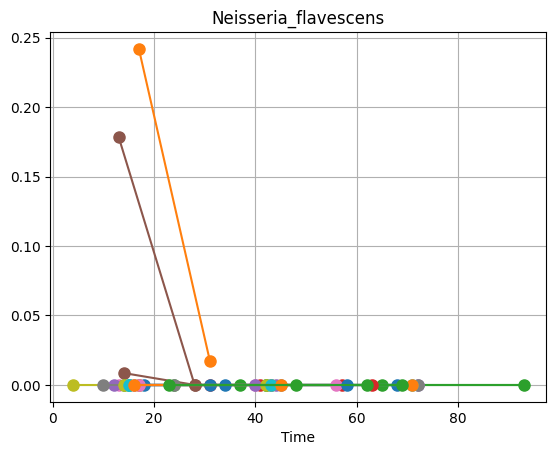

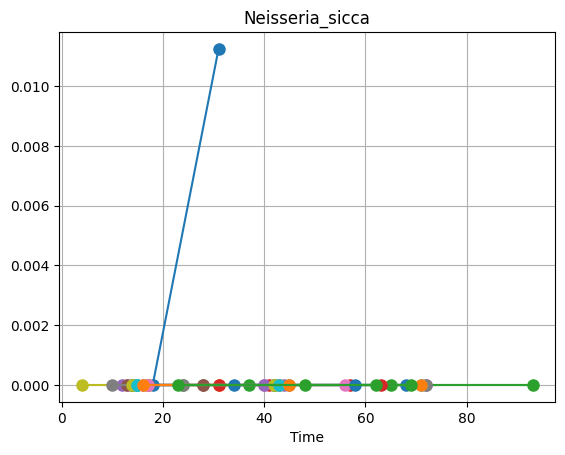

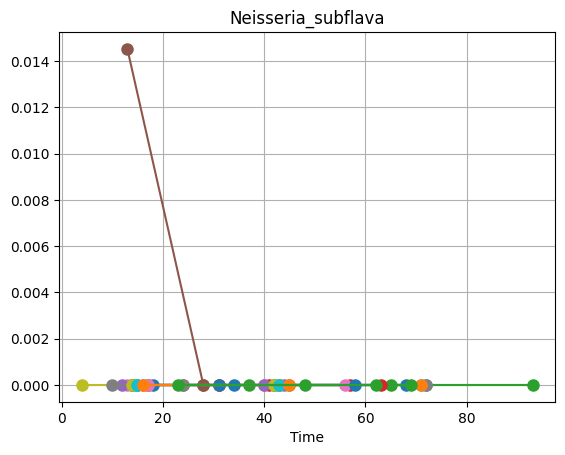

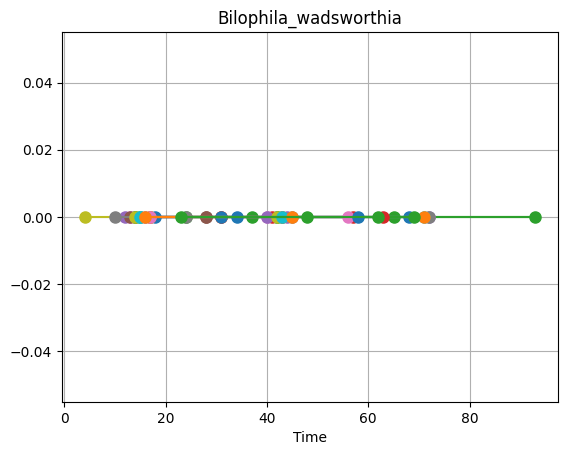

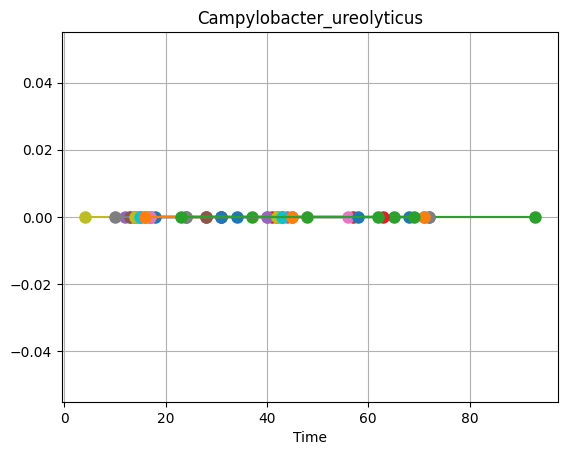

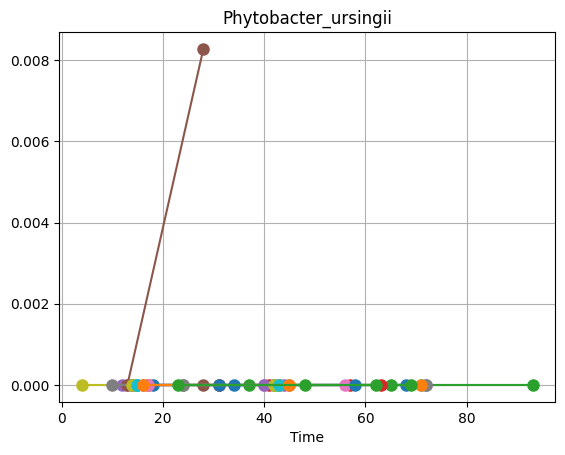

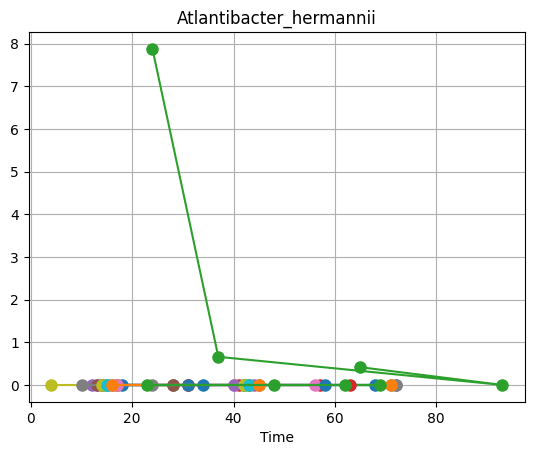

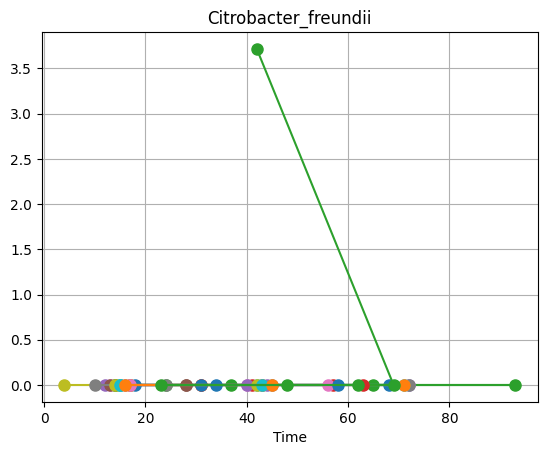

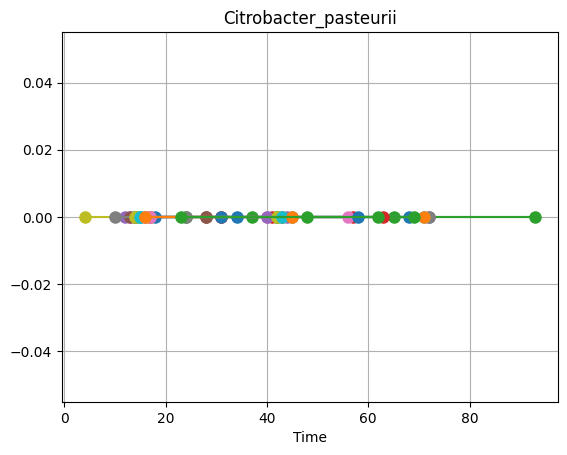

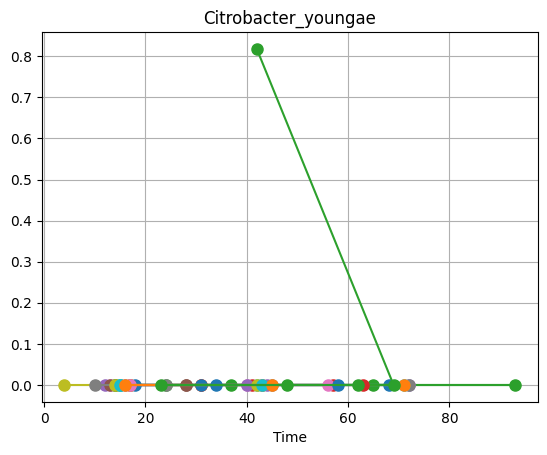

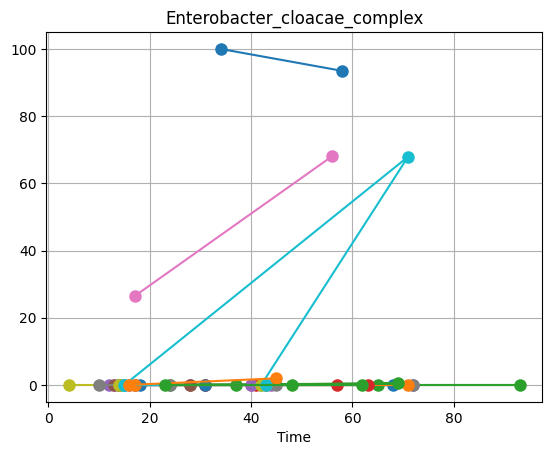

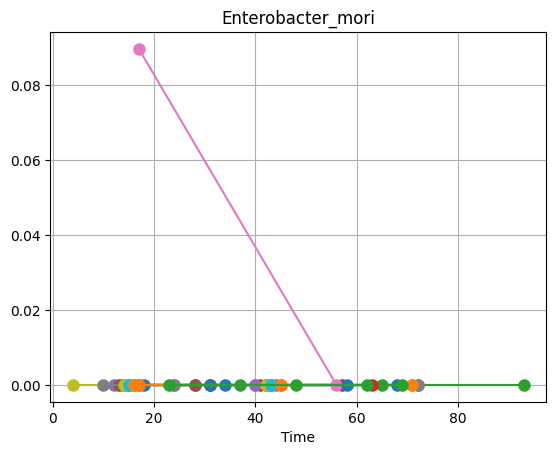

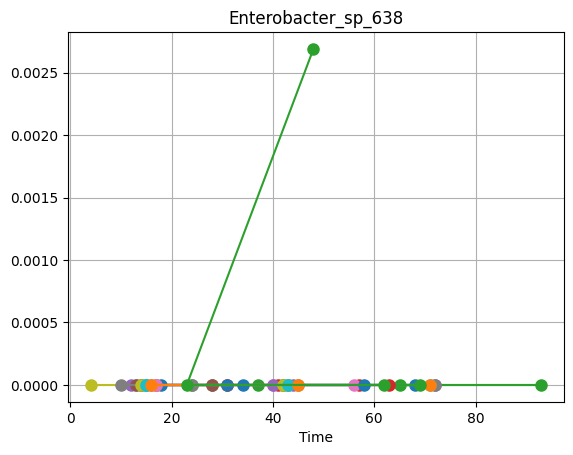

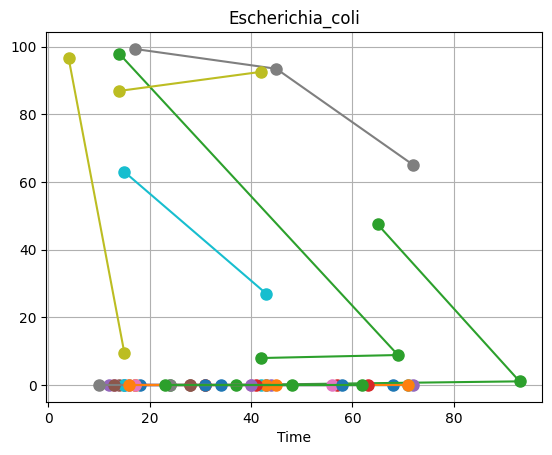

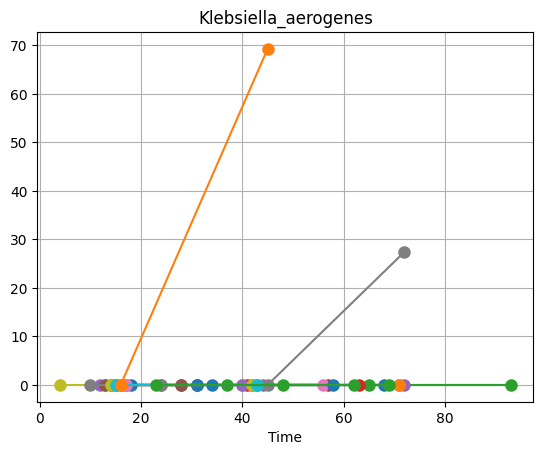

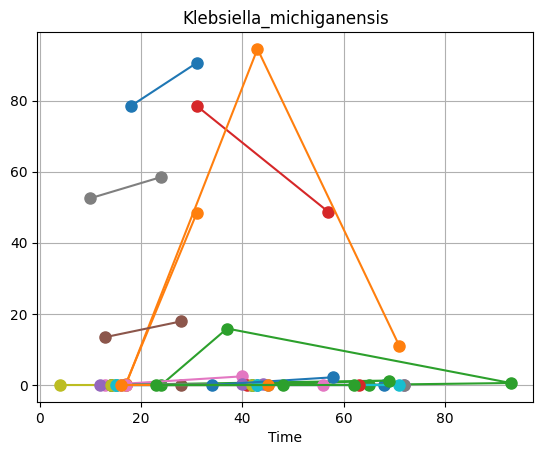

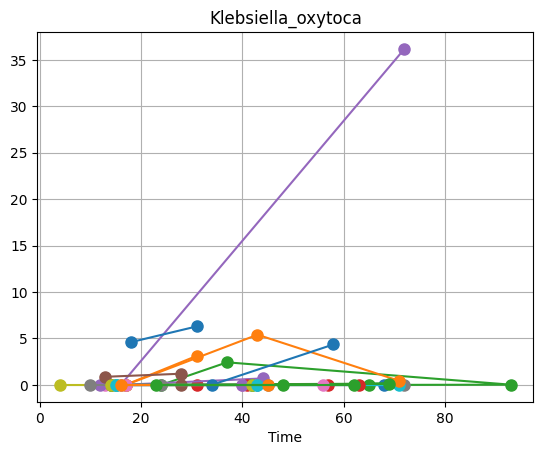

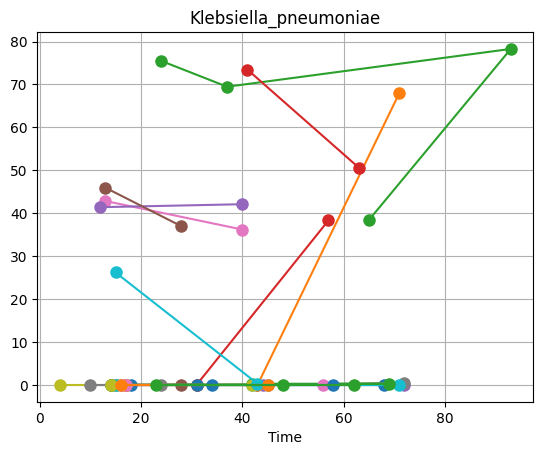

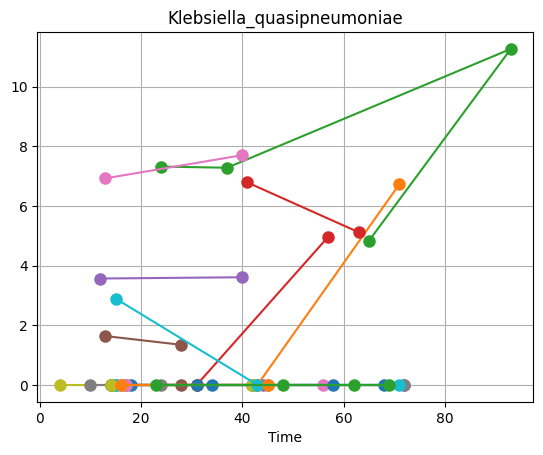

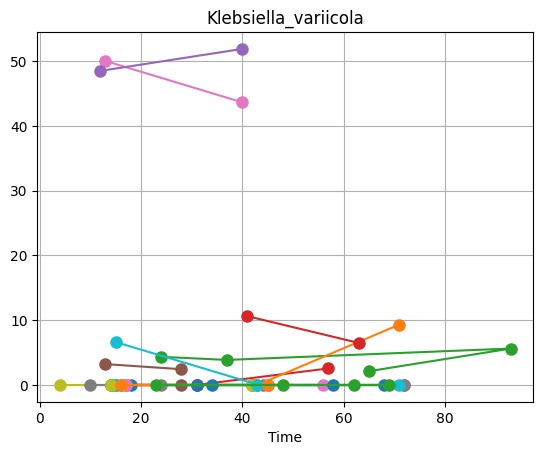

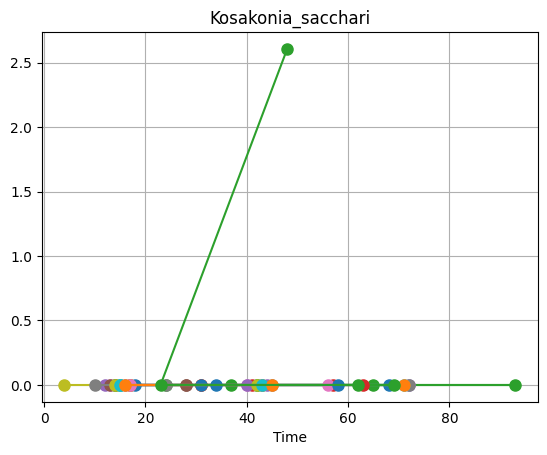

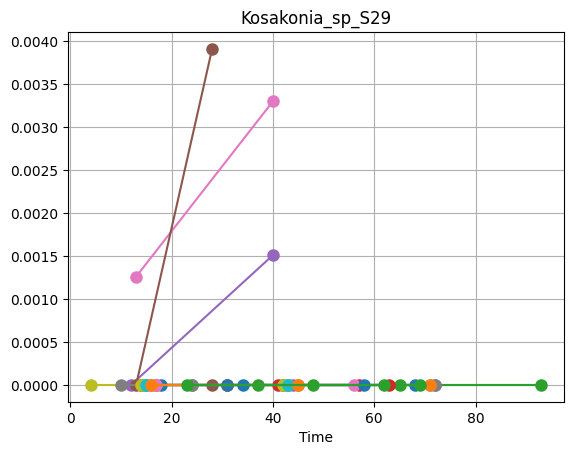

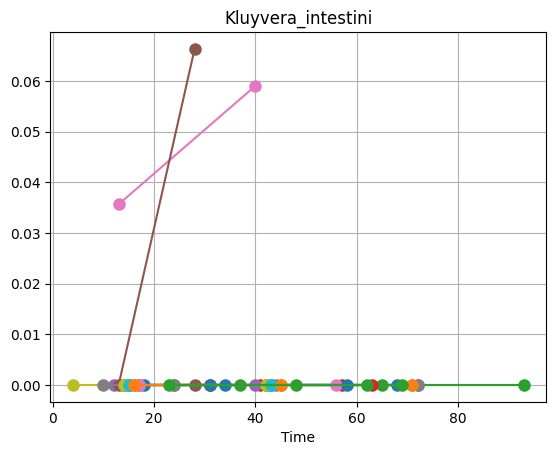

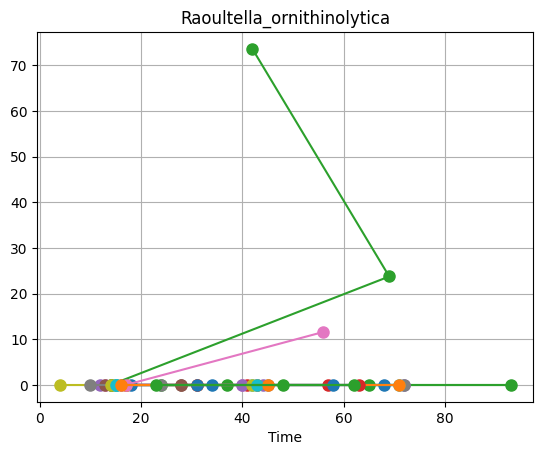

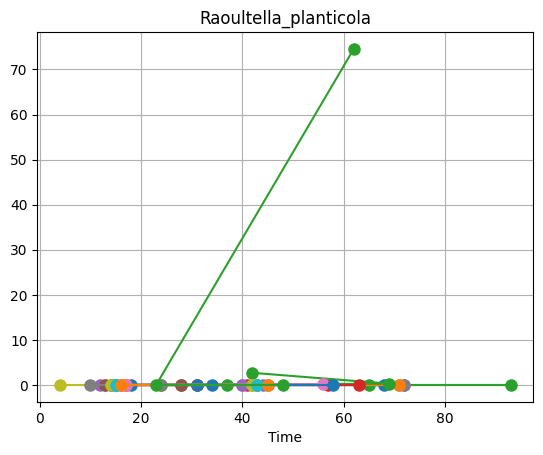

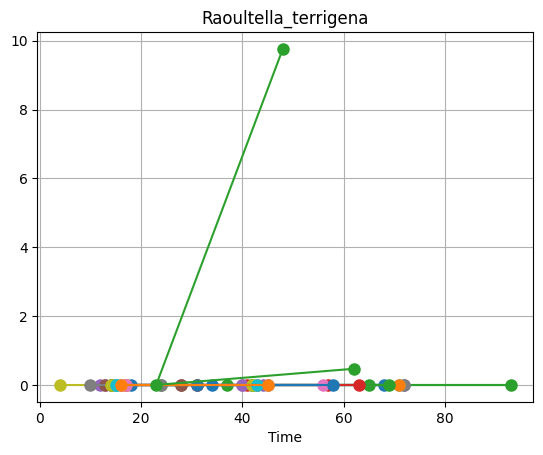

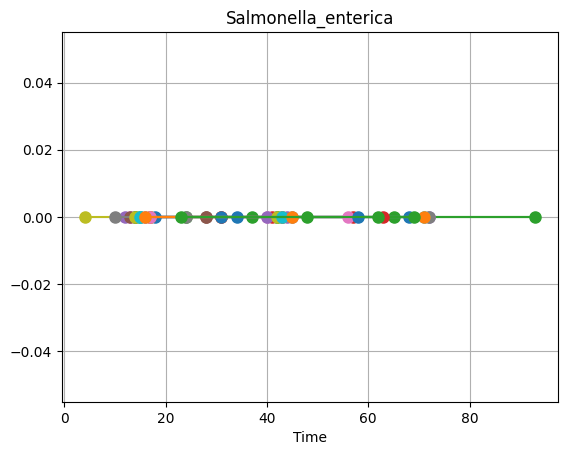

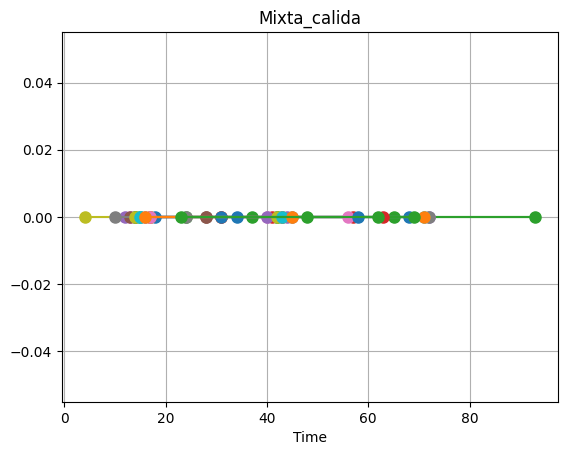

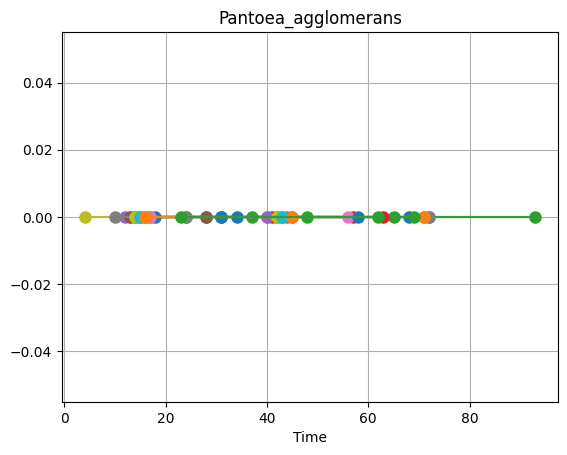

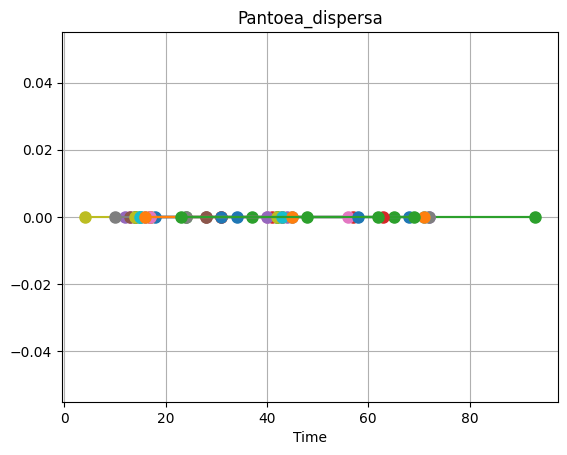

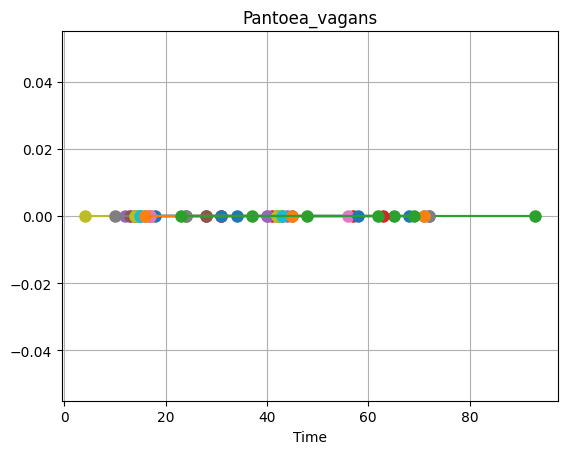

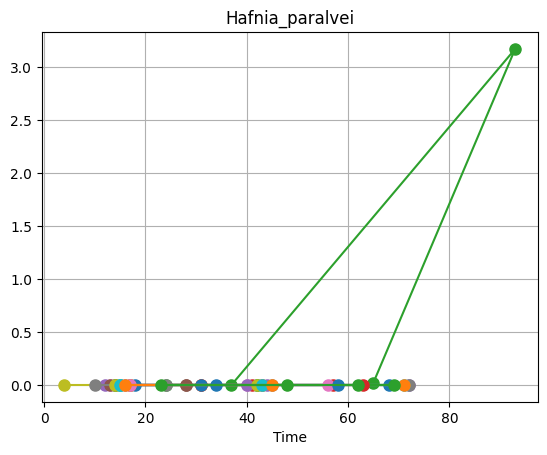

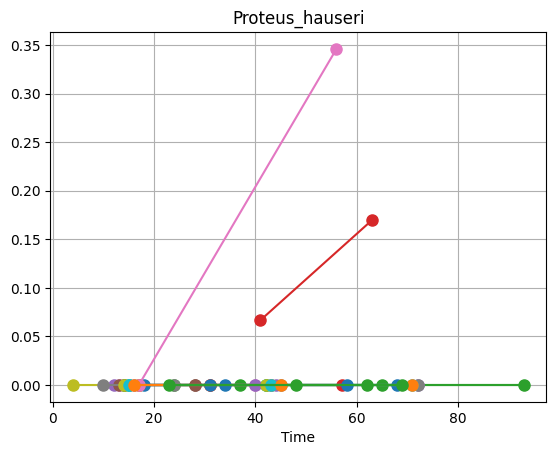

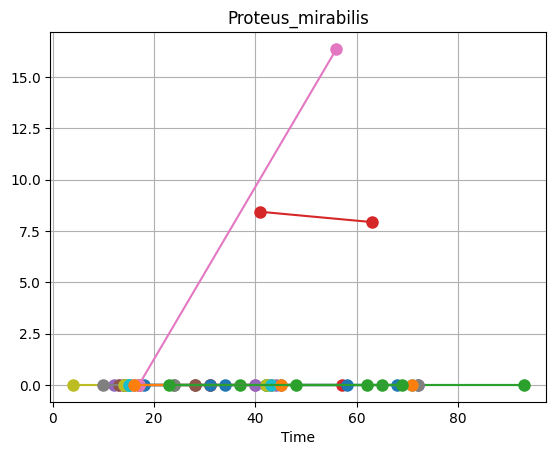

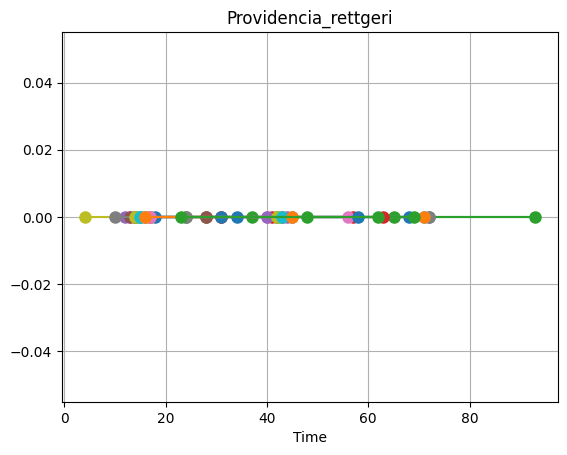

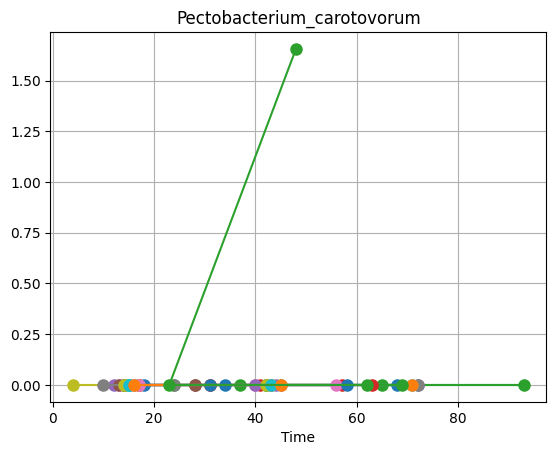

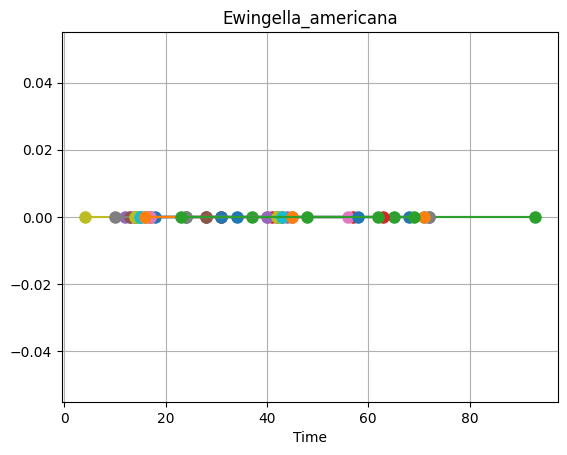

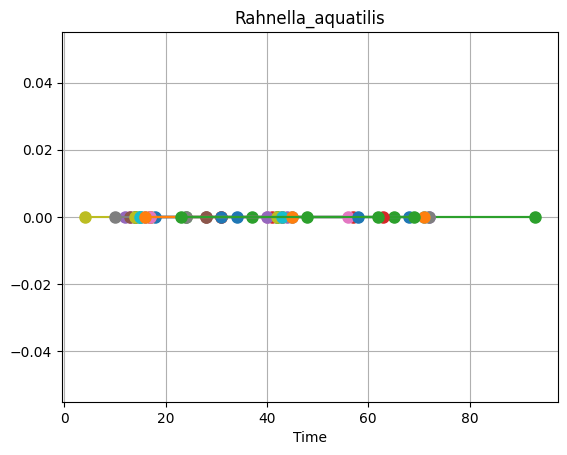

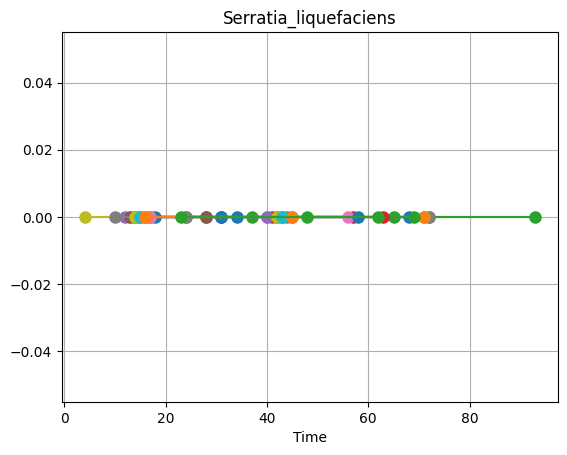

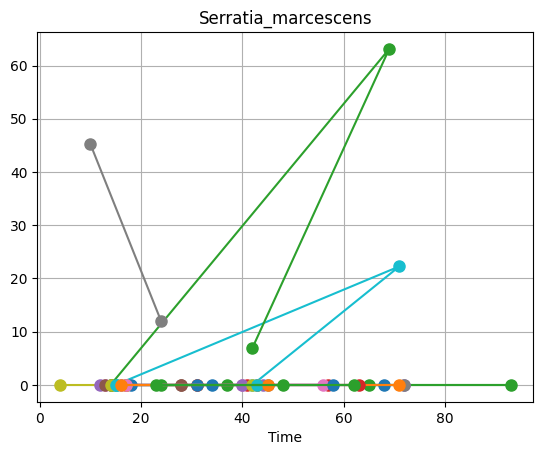

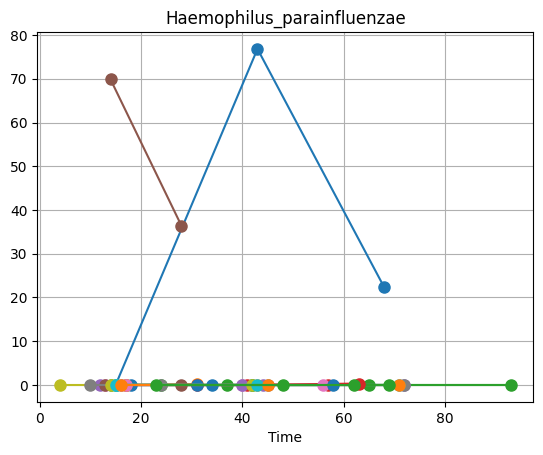

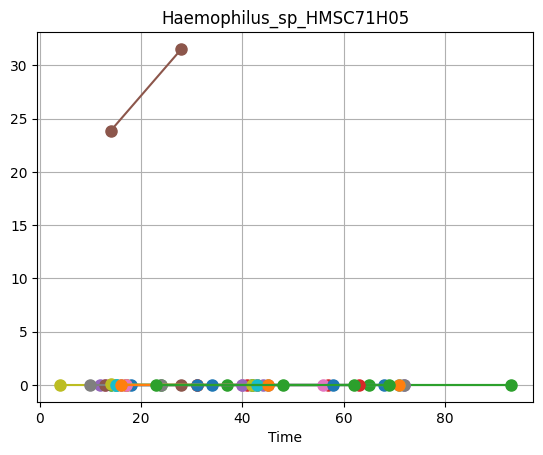

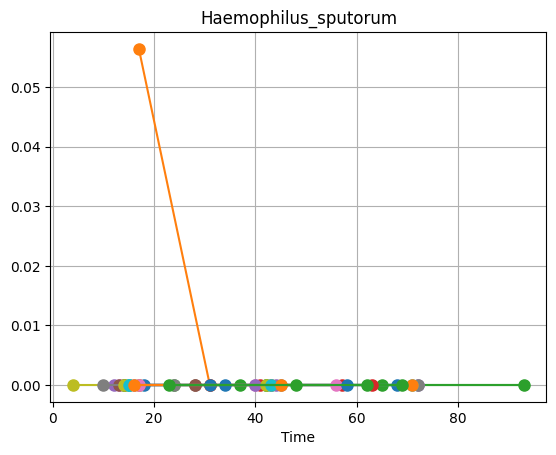

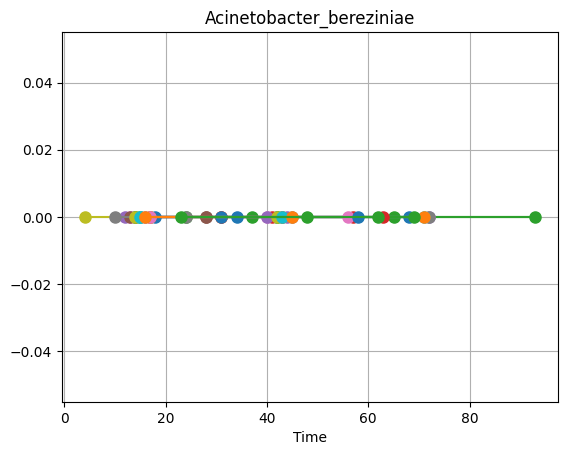

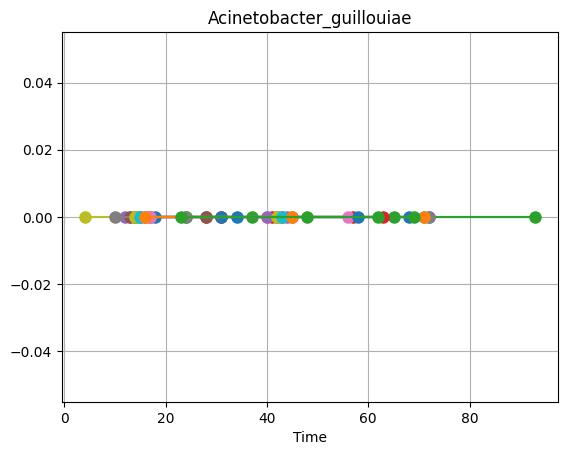

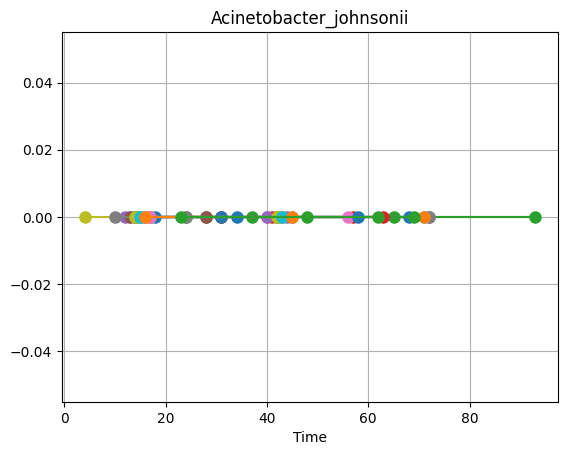

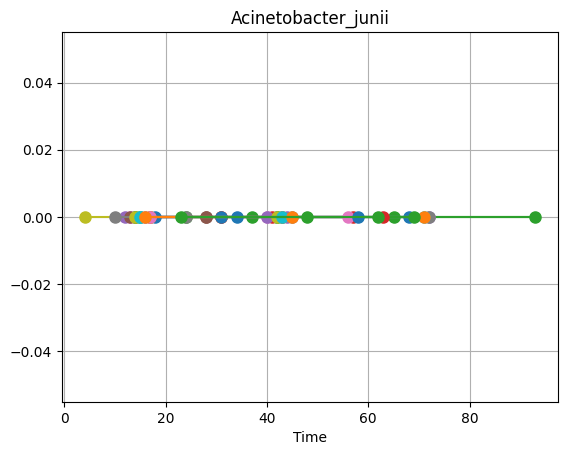

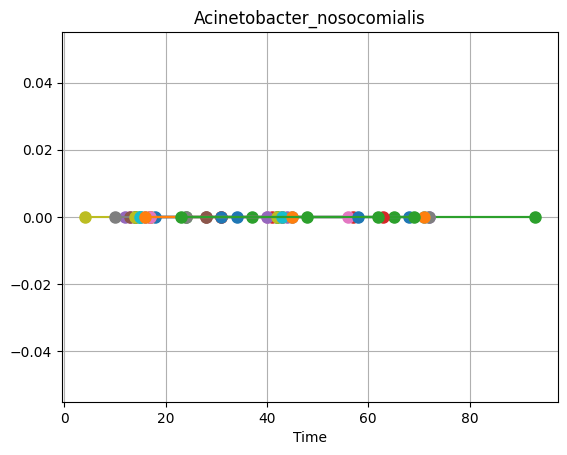

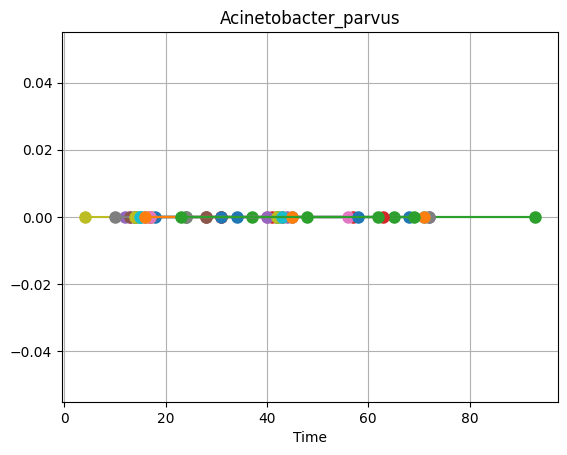

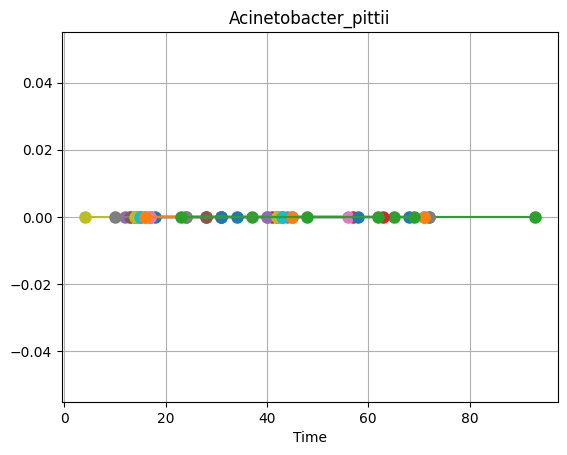

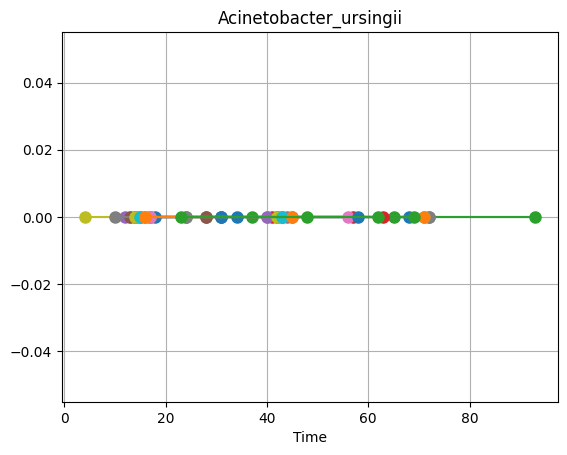

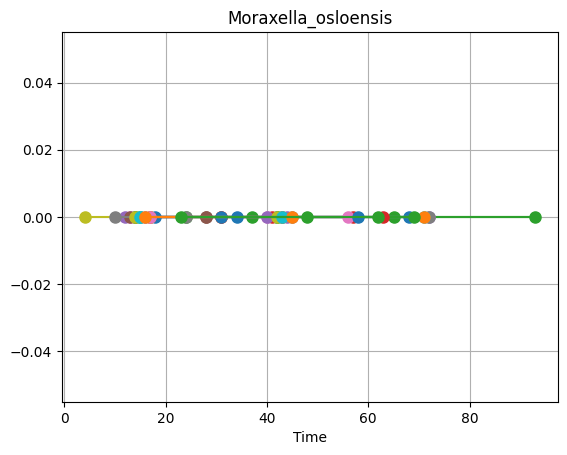

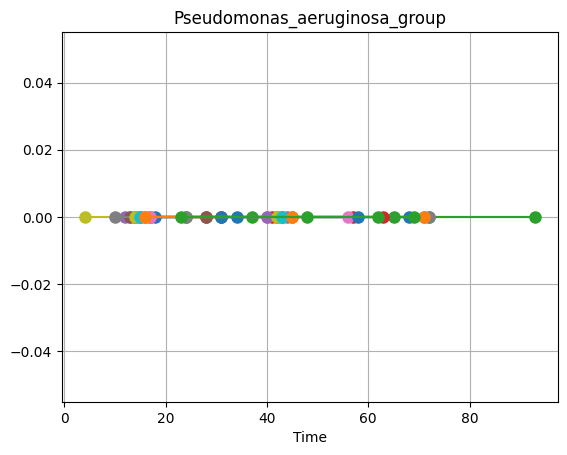

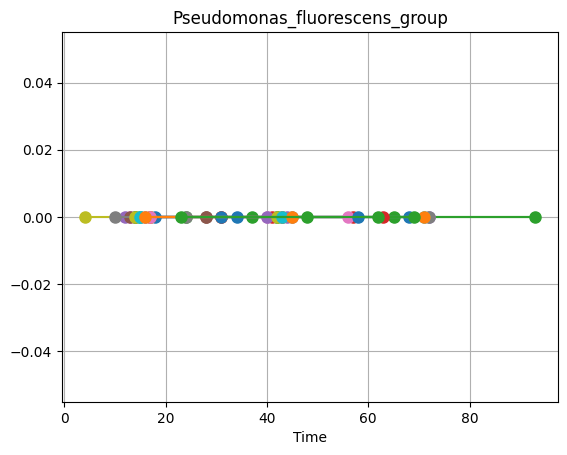

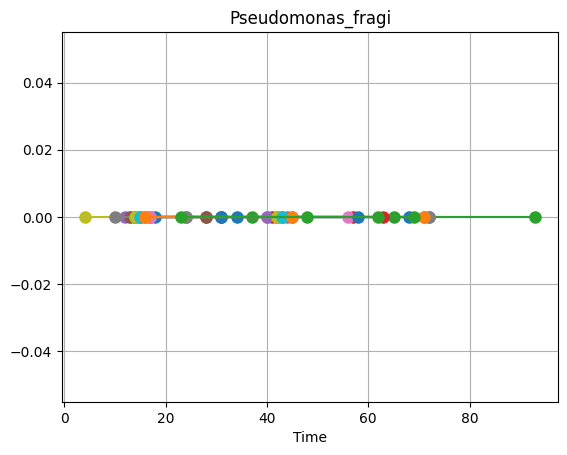

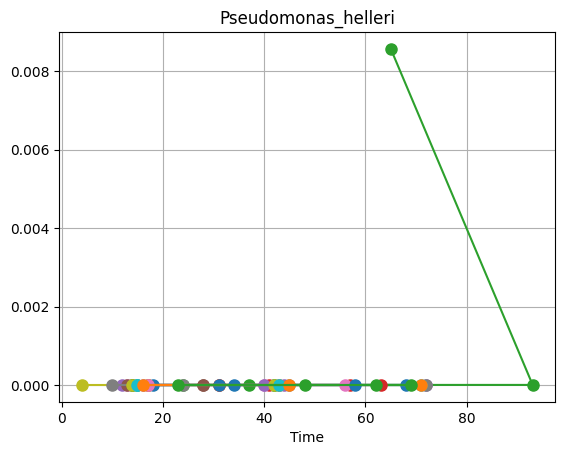

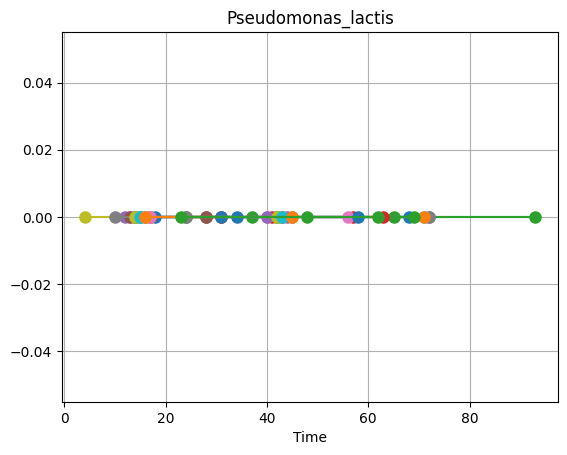

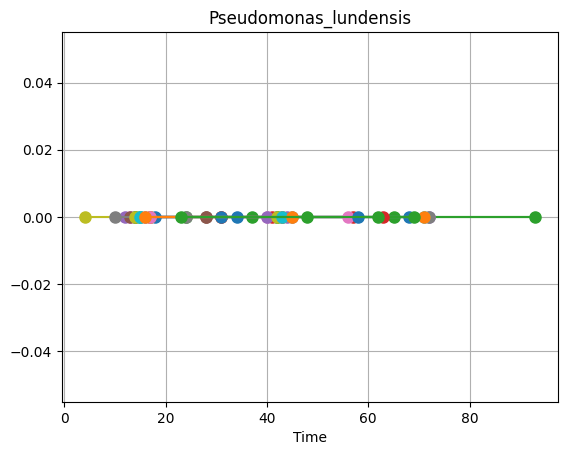

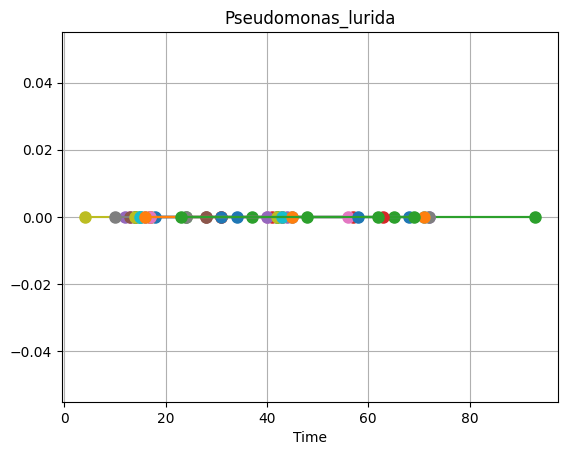

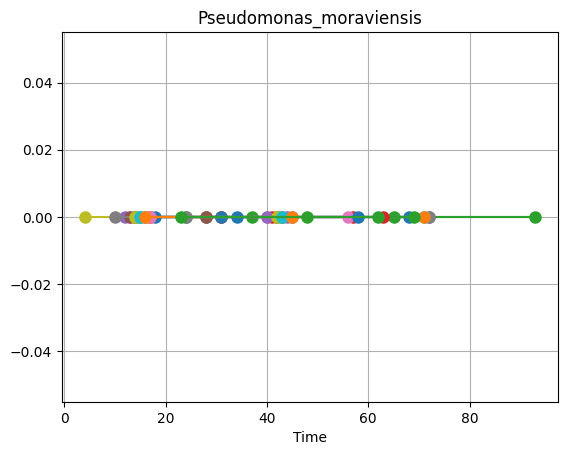

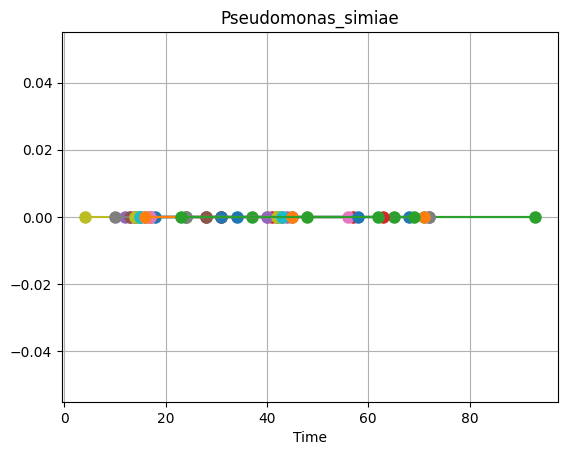

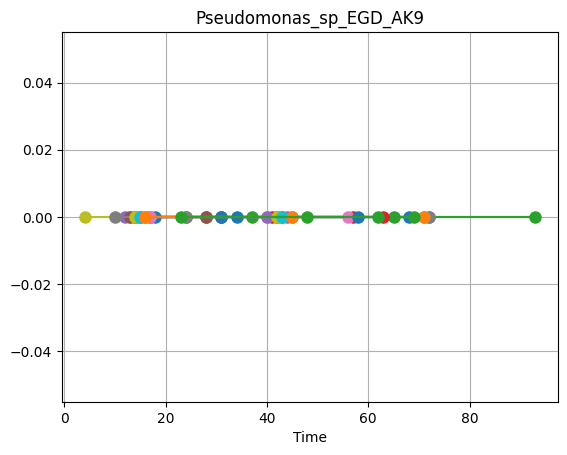

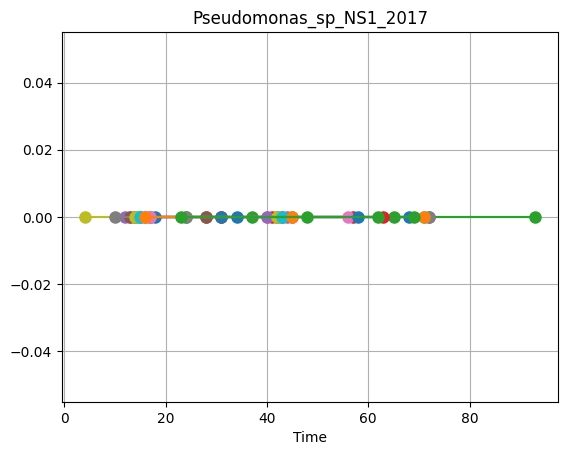

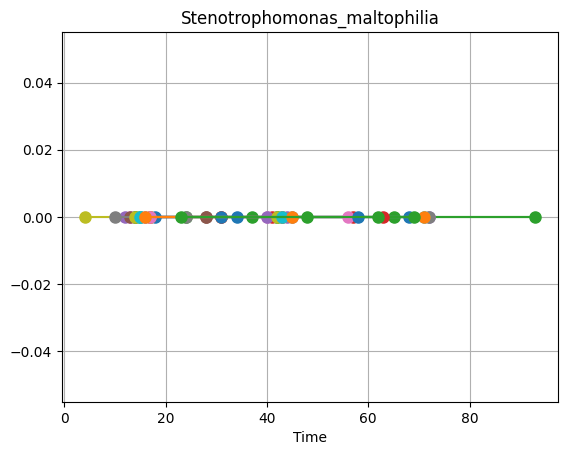

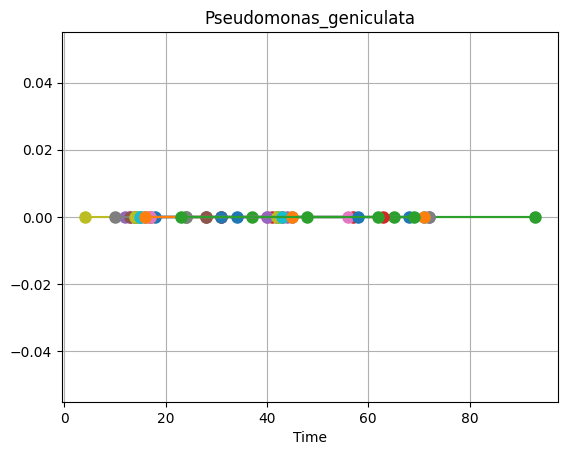

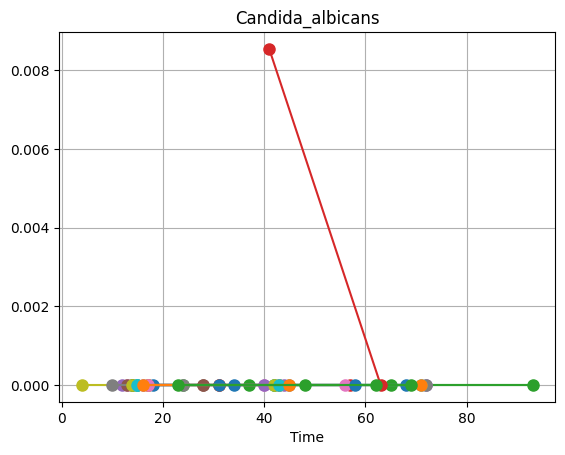

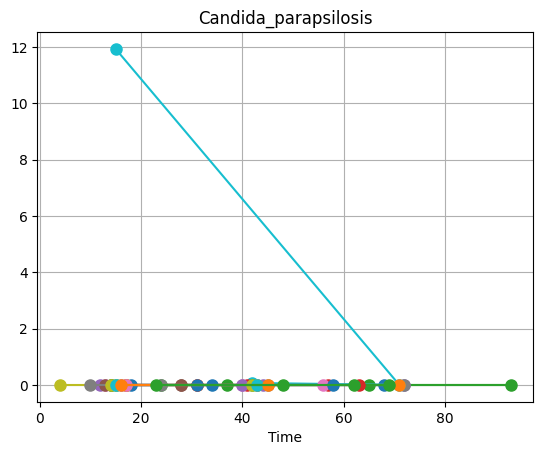

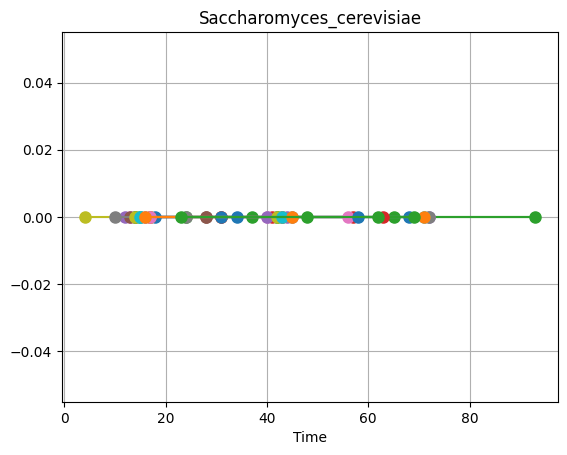

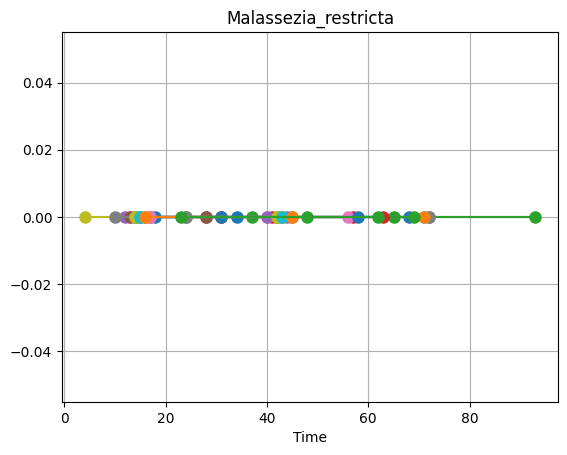

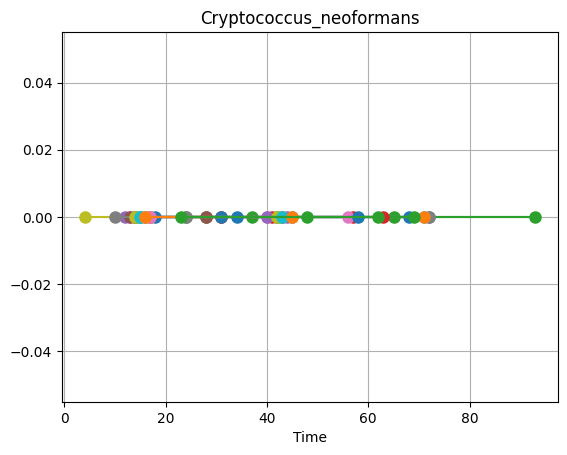

In [21]:
# Get the unique index values
unique_indexes = df['index'].unique()


# Column names excluding 'index' and 'time'
column_names = df.columns[9:]

# Iterate over the columns
for out in column_names:
    # Initialize a list to store the indexes with at least two measurements
    valid_indexes = []

    # Check for each index if it has at least two measurements
    for i in unique_indexes:
        if df.loc[df['index'] == i, out].count() >= 2:
            valid_indexes.append(i)
    
    # Plot data for valid indexes
    for i in valid_indexes:
        plt.plot(df.loc[df['index'] == i, 'time'], df.loc[df['index'] == i, out], marker='o', markersize=8, linestyle='-')

    plt.title(out)
    plt.xlabel('Time')
    plt.grid(True)
    # plt.savefig('tp_infant_microbiome.png')
    plt.show()

In the following cell we we restrict our analysis to the microbes with certain amount of dample size.

In [22]:
data_columns = df.columns[~df.columns.isin(['X','index','date','season','time','Winter','Fall','Spring','Summer'])]
print(data_columns)
selected_columns = []
for col in data_columns:
    # Filter the DataFrame to include only rows where the column is nonzero
    nonzero_rows = df[df[col] != 0]
    # print(nonzero_rows)
    # Count the unique 'index' groups with at least 2 nonzero values
    index_counts = nonzero_rows.groupby('index')[col].count()
    # print(index_counts)
    #### Check if there are at least 3 unique 'index' groups with at least 2 nonzero values
    if (index_counts >= 2).sum() >= 3:
        selected_columns.append(col)
print(selected_columns)
print(len(selected_columns))

Index(['Actinomyces_neuii', 'Actinomyces_odontolyticus',
       'Actinomyces_radingae', 'Actinomyces_sp_HMSC035G02',
       'Actinomyces_sp_oral_taxon_181', 'Varibaculum_cambriense',
       'Aeriscardovia_aeriphila', 'Alloscardovia_omnicolens',
       'Bifidobacterium_bifidum', 'Bifidobacterium_breve',
       ...
       'Pseudomonas_simiae', 'Pseudomonas_sp_EGD_AK9',
       'Pseudomonas_sp_NS1_2017', 'Stenotrophomonas_maltophilia',
       'Pseudomonas_geniculata', 'Candida_albicans', 'Candida_parapsilosis',
       'Saccharomyces_cerevisiae', 'Malassezia_restricta',
       'Cryptococcus_neoformans'],
      dtype='object', name=0, length=201)
['Bifidobacterium_breve', 'Cutibacterium_avidum', 'Staphylococcus_epidermidis', 'Enterococcus_faecalis', 'Streptococcus_mitis', 'Clostridium_perfringens', 'Enterobacter_cloacae_complex', 'Escherichia_coli', 'Klebsiella_michiganensis', 'Klebsiella_oxytoca', 'Klebsiella_pneumoniae', 'Klebsiella_quasipneumoniae', 'Klebsiella_variicola', 'Haemophilus_pa

Only for the aim of the demo we just include the effect of 'time' in the analysis.  

In [23]:
for col in selected_columns:
    df[col] = np.log(np.floor(df[col] * 10**6)+1).astype(float)
gps = GPSearch(X=df[['index','time']].astype(float),
                    Y=df[['Bifidobacterium_breve', 'Cutibacterium_avidum', 'Staphylococcus_epidermidis', 'Enterococcus_faecalis', 
                          'Streptococcus_mitis', 'Clostridium_perfringens', 'Escherichia_coli', 'Klebsiella_michiganensis', 
                          'Klebsiella_oxytoca', 'Klebsiella_pneumoniae', 'Klebsiella_quasipneumoniae', 
                          'Klebsiella_variicola']].astype(float),
                    unit_col='index',
                    categorical_vars=[],
                    outcome_likelihood= 'gaussian')#'poisson')

In [24]:
gps.run_search(
    random_seed=9102
)

Kernel search: 100%|███████████████████████████████████████████████████████████████████| 12/12 [00:48<00:00,  4.01s/it]


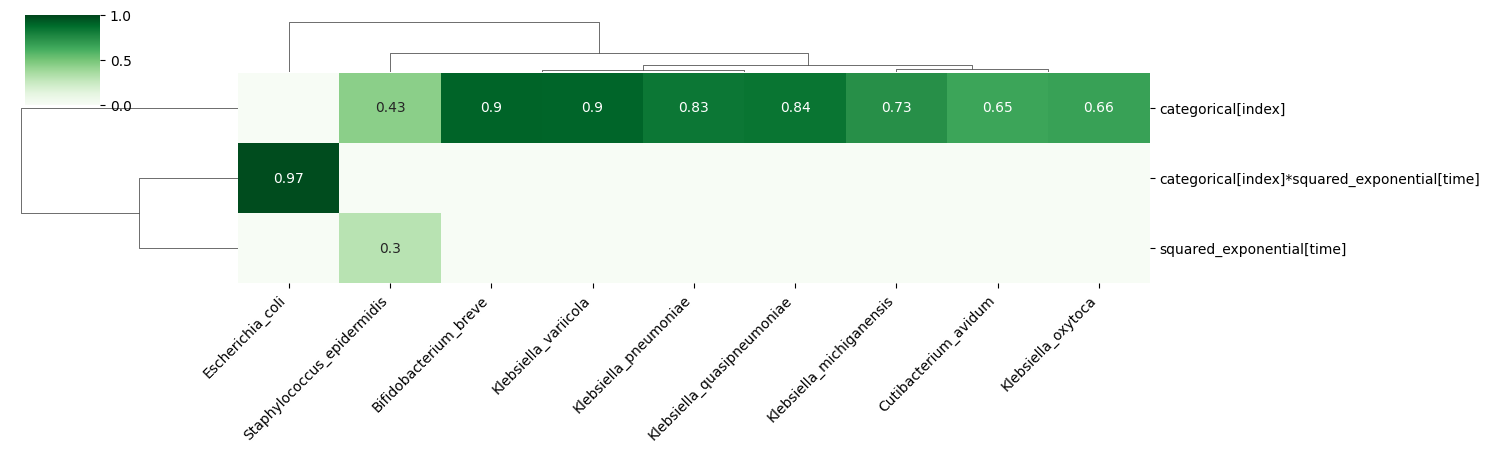

In [25]:
gps.plot_heatmap(var_cutoff=0.1)

(<Figure size 2000x500 with 2 Axes>,
 array([[<Axes: title={'center': 'categorical[index]*\nsquared_exponential[time](97.5%)'}, xlabel='time'>,
         <Axes: title={'center': 'residuals (2.5%)'}, xlabel='time'>,
         <Axes: >, <Axes: >]], dtype=object))

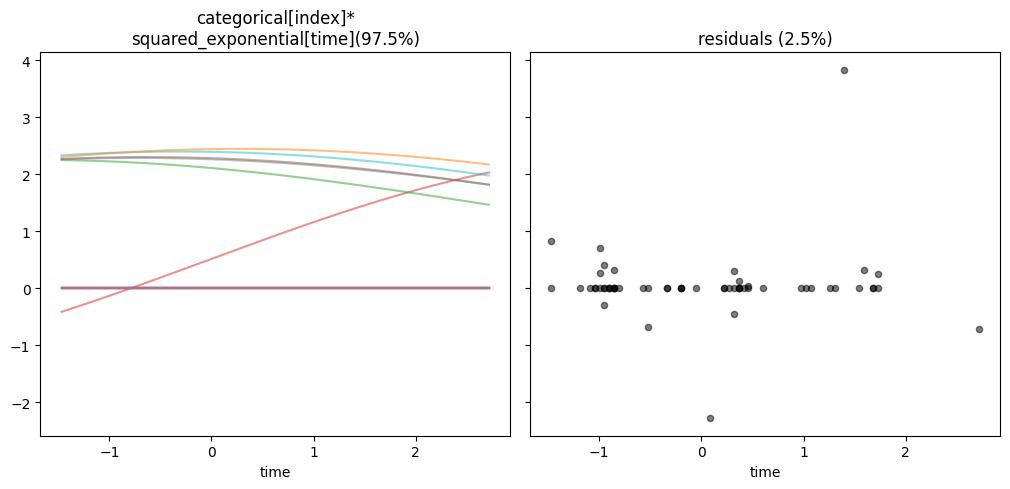

In [26]:
gps.plot_parts(
    out_label='Escherichia_coli', 
    x_axis_label='time',
    unit_label=0
)

(<Figure size 2000x500 with 3 Axes>,
 array([[<Axes: title={'center': 'categorical[index](43.4%)'}, xlabel='time'>,
         <Axes: title={'center': 'squared_exponential[time](29.8%)'}, xlabel='time'>,
         <Axes: title={'center': 'residuals (26.7%)'}, xlabel='time'>,
         <Axes: >]], dtype=object))

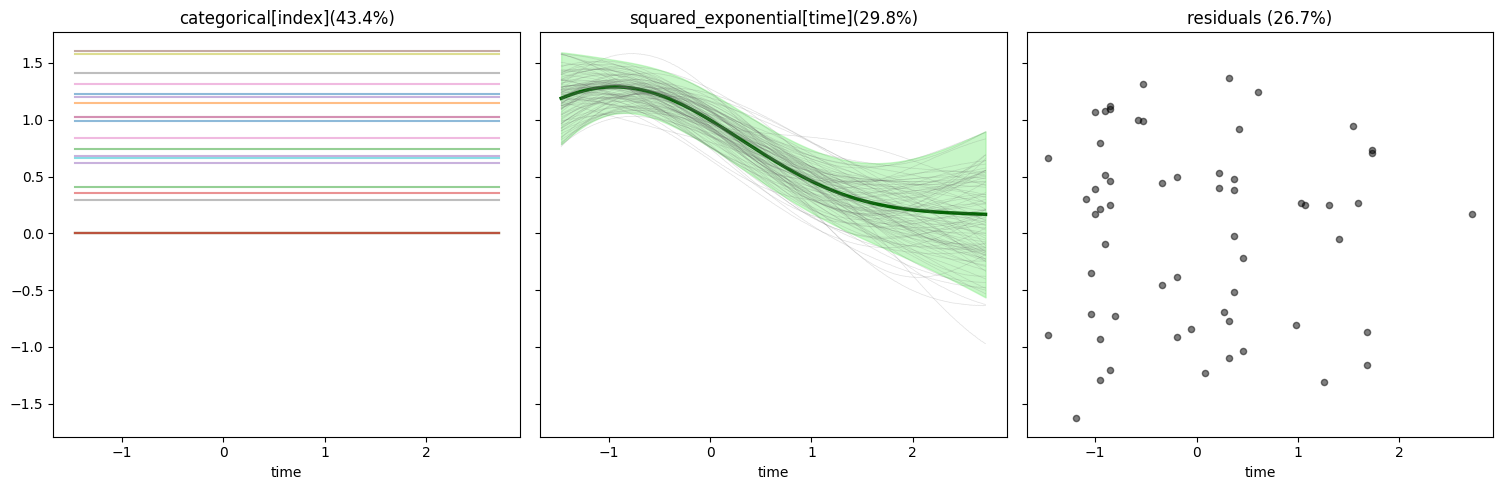

In [27]:
gps.plot_parts(
    out_label='Staphylococcus_epidermidis', 
    x_axis_label='time',
    unit_label=0
)

Finally, we might be interested in seeing the relationships found between outcomes during the search process. We can view this with a heatmap like the one shown below. Each row is an additive model component, each column is an outcome, and the filled in values are the explained variation of the outcome by that model component.

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


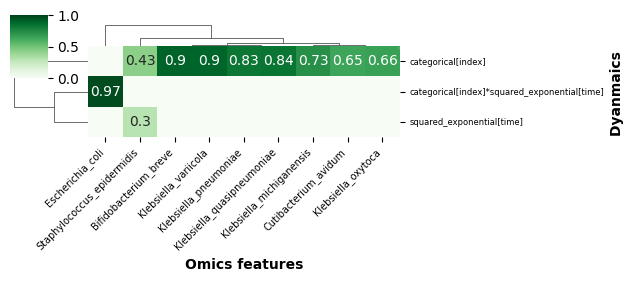

In [28]:
import pylab
import matplotlib.pyplot as plt
import seaborn as sns
annot_kws={"size": 1}
fig = gps.plot_heatmap(var_cutoff=0.1, figsize = (7.5, 3.5))
ax_heatmap = fig.ax_heatmap
# Set xlabel on the heatmap axes
ax_heatmap.set_xlabel('Omics features', fontweight='bold', fontsize=10)
ax_heatmap.set_ylabel('Dyanmaics ', fontweight='bold', fontsize=10)

ax_heatmap.legend(framealpha = 0.2,prop={'size':1}) 

ax_heatmap.get_xaxis().set_tick_params(which='both', labelsize=7)# top='off', bottom='on', direction='out')
ax_heatmap.get_yaxis().set_tick_params(which='both', labelsize=6)

# plt.savefig('<PATH_TO_YOUR_DIRECTORY>/rest_metrics1.pdf', dpi=350, bbox_inches = "tight") 

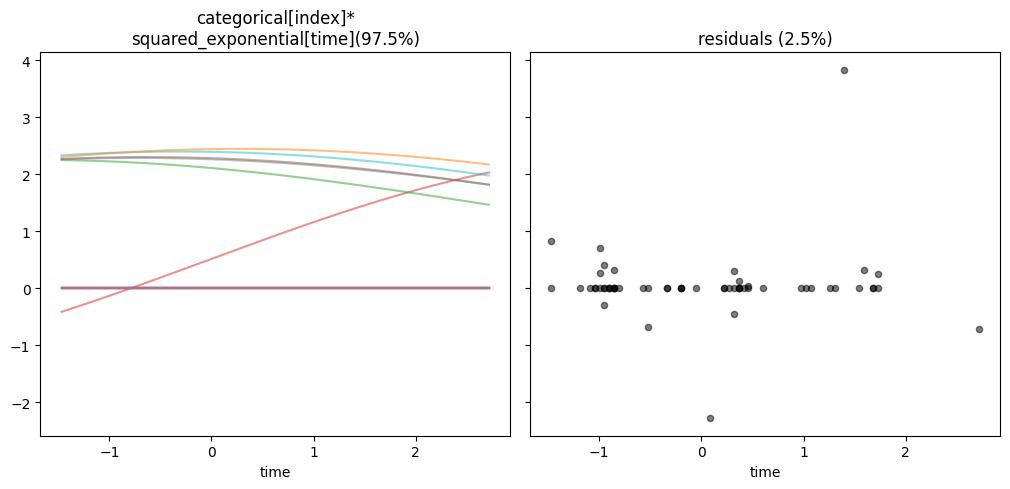

In [30]:
import pylab
import matplotlib.pyplot as plt
import seaborn as sns
annot_kws={"size": 1}
#plt.rcParams['figure.figsize'] = 10, 3
#plt.figure(figsize=(7.2, 3))
# Assuming `gps` is your ClusterGrid
parts = gps.plot_parts(
    out_label='Escherichia_coli', 
    x_axis_label='time',
    unit_label=0
)
#plt = pylab.figure(figsize=(3, 2.5))
#plt.figure(figsize=(7.2, 3))
# Access the heatmap axes directly
# ax_heatmap = parts.ax_heatmap
# # Set xlabel on the heatmap axes
ax_heatmap.set_xlabel('Omics features', fontweight='bold', fontsize=10)
ax_heatmap.set_ylabel('Dyanmaics ', fontweight='bold', fontsize=10)


# ax_heatmap.legend(framealpha = 0.2,prop={'size':1}) 

# ax_heatmap.get_xaxis().set_tick_params(which='both', labelsize=7)# top='off', bottom='on', direction='out')
# ax_heatmap.get_yaxis().set_tick_params(which='both', labelsize=6)

# plt.savefig('<PATH_TO_FILE>/parts_Escherichia_coli.pdf', dpi=350, bbox_inches = "tight") 
# plt.savefig('<PATH_TO_FILE>/Figures/rest_metrics.png', dpi=350, bbox_inches = "tight") 
plt.show()